In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

In [3]:
#load_dataset
with open("./zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")

In [4]:
#merge train_set and test_set
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)


In [5]:
data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

In [6]:
# normalise numeric columns
cols_numeric=list(data_all.columns)
cols_numeric.remove("oringin")
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col!='target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax,axis=0)

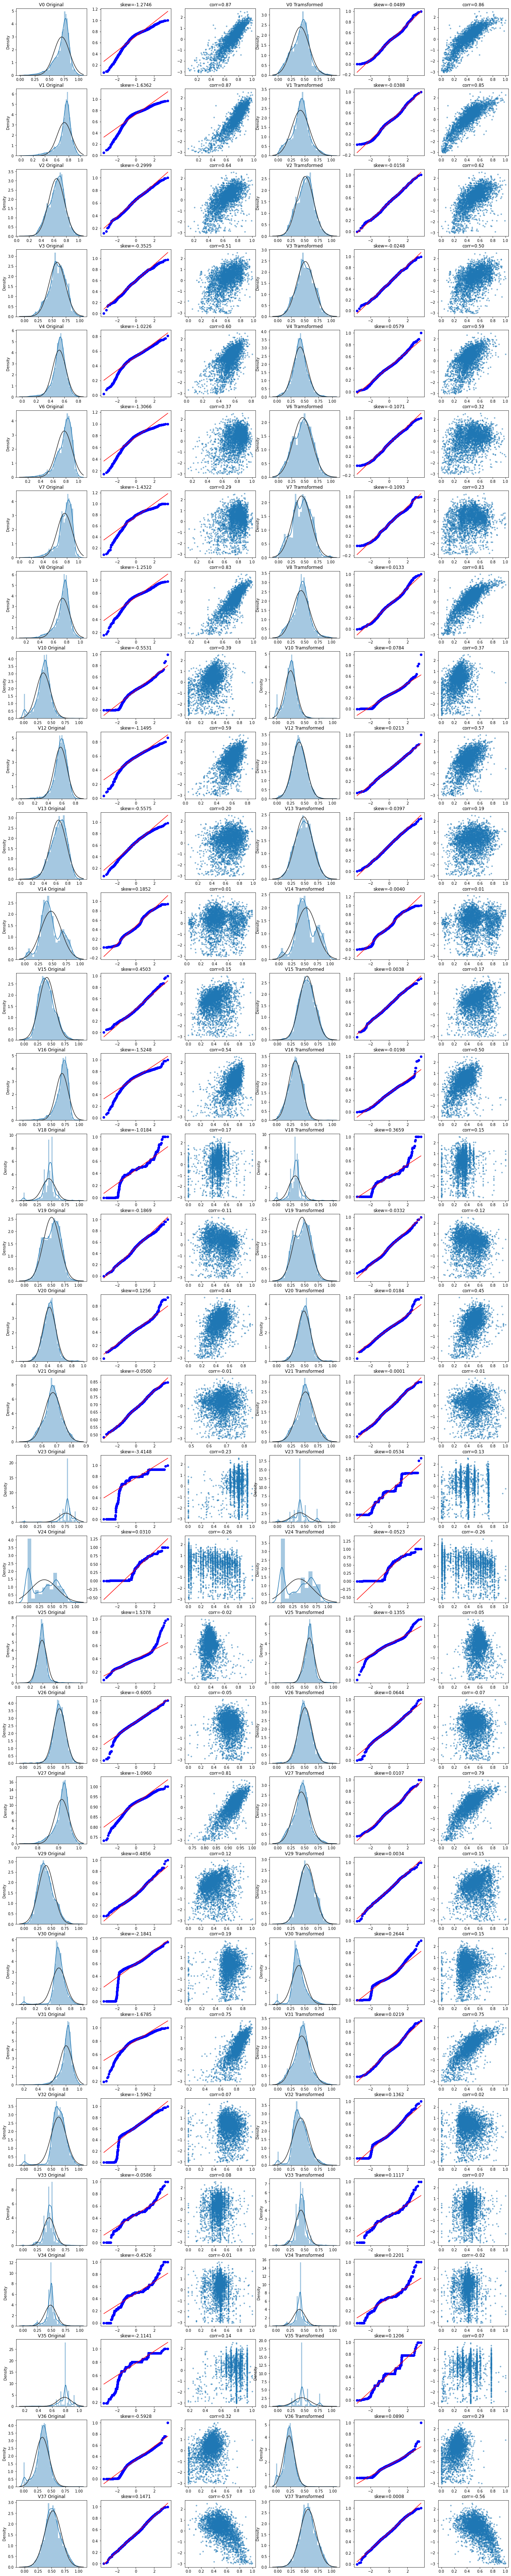

In [7]:
#Check effect of Box-Cox transforms on distributions of continuous variables

fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric:
    if var!='target':
        dat = data_all[[var, 'target']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

In [8]:
# 对特征进行Box-Cox变换，使其满足正态性
cols_transform=data_all.columns[0:-2]
for col in cols_transform:   
    # transform column
    data_all.loc[:,col], _ = stats.boxcox(data_all.loc[:,col]+1)

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


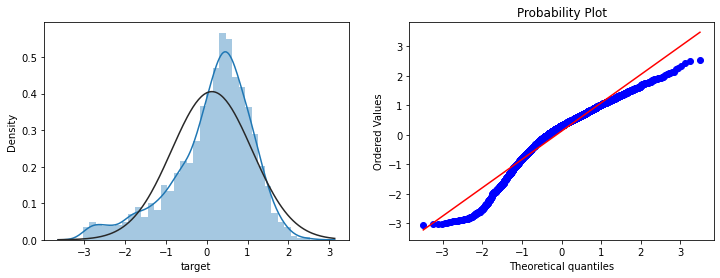

In [9]:
# 标签数据统计转换后的数据，计算分位数画图展示（基于正态分布）
print(data_all.target.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_all.target.dropna(), plot=plt)

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


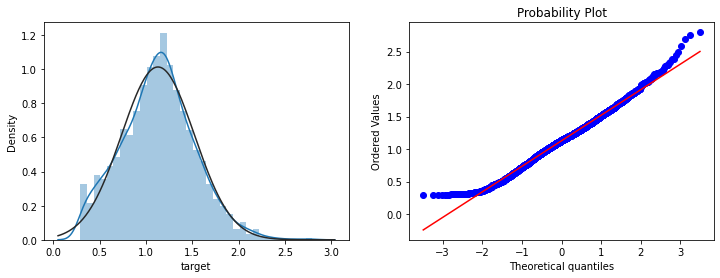

In [10]:
# 标签数据对数变换数据，使数据更符合正态，并画图展示
#Log Transform SalePrice to improve normality
sp = data_train.target
data_train.target1 =np.power(1.5,sp)
print(data_train.target1.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_train.target1.dropna(), plot=plt)

In [14]:
# 获取训练和测试数据
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"]=="train"]
    df_train["label"]=data_train.target1
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin","target","label"],axis=1)
    X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.3,random_state=100)
    return X_train,X_valid,y_train,y_valid

# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"]=="test"].reset_index(drop=True)
    return df_test.drop(["oringin","target"],axis=1)

In [12]:
from sklearn.metrics import make_scorer
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)
def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mse_scorer = make_scorer(mse, greater_is_better=False)

In [15]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.8794138470953502
rmse= 0.3451033881505013
mse= 0.11909634851295575
---------------------------------------
mean of residuals: 1.204160747144158e-16
std of residuals: 0.3451887992118639
---------------------------------------
23 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 776, 2625, 884, 2696, 2668, 1310, 1901, 2769, 2002, 2669, 1040]


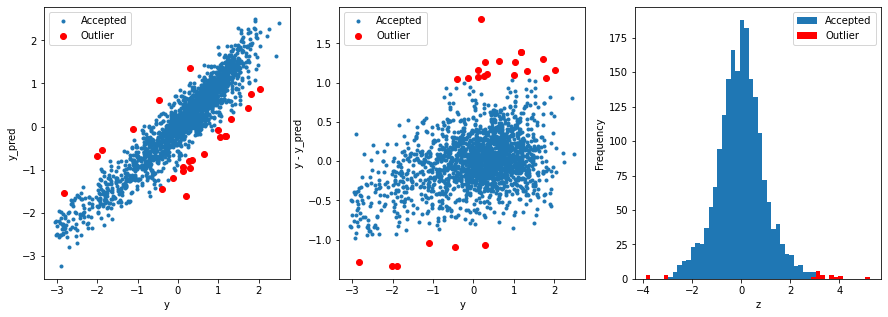

In [16]:
# get training data
from sklearn.linear_model import Ridge
X_train, X_valid,y_train,y_valid = get_training_data()
test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
#df_train = data_all[data_all["oringin"]=="train"]
#df_train["label"]=data_train.target1
#df_train=df_train.drop(outliers)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

R2= 0.8794138470953502
rmse= 0.3451033881505013
mse= 0.11909634851295575
---------------------------------------
mean of residuals: 1.204160747144158e-16
std of residuals: 0.3451887992118639
---------------------------------------
23 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 776, 2625, 884, 2696, 2668, 1310, 1901, 2769, 2002, 2669, 1040]


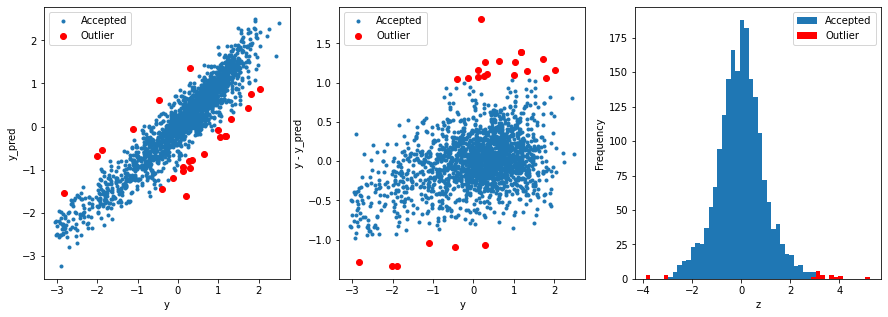

In [17]:
# get training data
from sklearn.linear_model import Ridge
X_train, X_valid,y_train,y_valid = get_training_data()
test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
#df_train = data_all[data_all["oringin"]=="train"]
#df_train["label"]=data_train.target1
#df_train=df_train.drop(outliers)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

In [18]:
def get_trainning_data_omitoutliers():
    y1=y_t.copy()
    X1=X_t.copy()
    return X1,y1

In [19]:
from sklearn.preprocessing import StandardScaler
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()
        #poly_trans=PolynomialFeatures(degree=2)
        #X=poly_trans.fit_transform(X)
        #X=MinMaxScaler().fit_transform(X)
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [20]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


----------------------
Ridge(alpha=0.25)
----------------------
score= 0.8963563382458094
rmse= 0.318996491999353
mse= 0.10175876190789339
cross_val: mean= 0.10599807694123355 , std= 0.008843783525742492


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    8.0s finished


Text(0, 0.5, 'score')

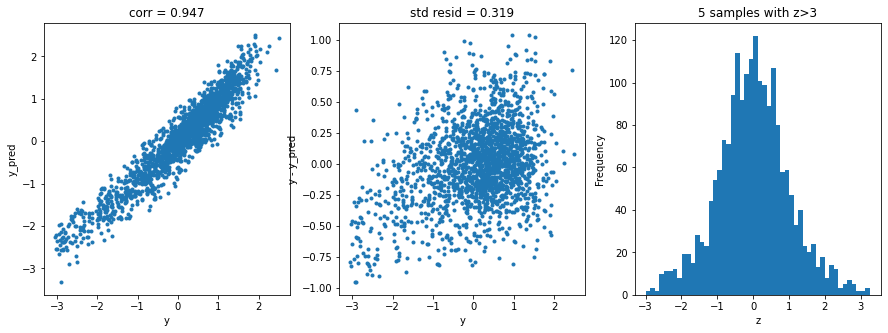

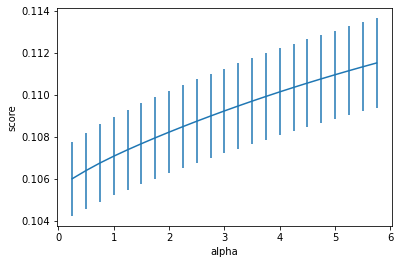

In [21]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   19.8s finished


----------------------
Lasso(alpha=0.0001)
----------------------
score= 0.8965376024713235
rmse= 0.3187174206360847
mse= 0.10158079421691907
cross_val: mean= 0.1061092371519506 , std= 0.007904325607879506


Text(0, 0.5, 'score')

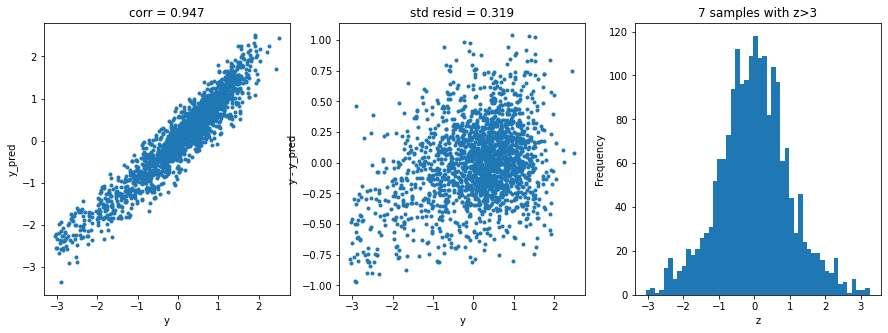

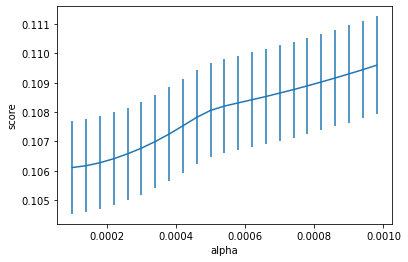

In [22]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   14.0s finished


----------------------
ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=100000)
----------------------
score= 0.8965268228807055
rmse= 0.3187340235464924
mse= 0.10159137776613573
cross_val: mean= 0.10590457955340879 , std= 0.007937384599668033


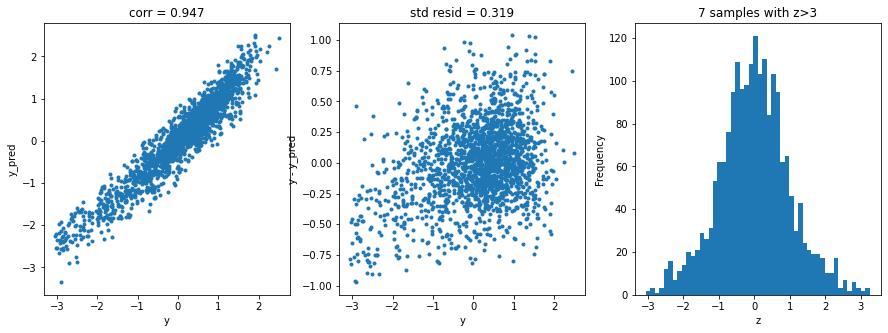

In [23]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   46.5s finished


----------------------
LinearSVR(C=0.9)
----------------------
score= 0.2888052873169882
rmse= 0.8356199358219146
mse= 0.6982606771430199
cross_val: mean= 1.3121075639085837 , std= 1.1219845728200997


Text(0, 0.5, 'score')

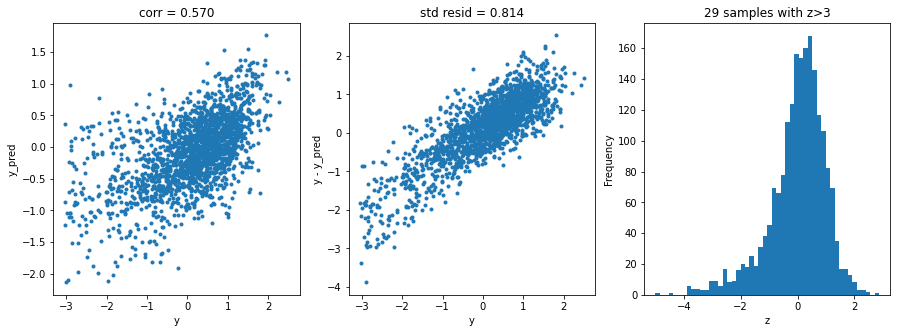

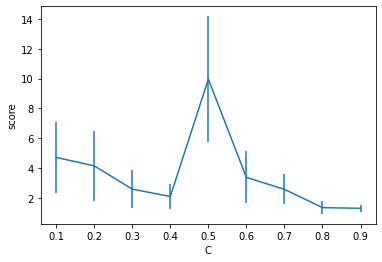

In [24]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange,
             'max_iter':[1000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)


cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score')


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished


----------------------
KNeighborsRegressor(n_neighbors=10)
----------------------
score= 0.7188007679386812
rmse= 0.5254381453364181
mse= 0.27608524457457456
cross_val: mean= 0.344411917096579 , std= 0.013327743147746745


Text(0, 0.5, 'score')

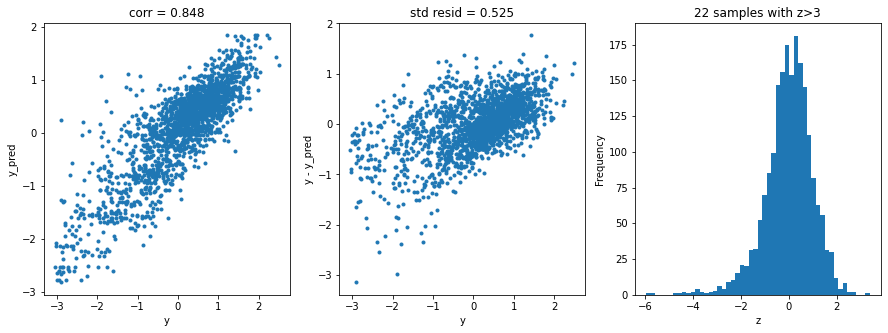

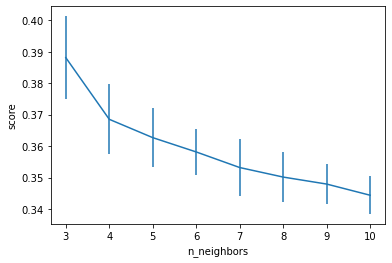

In [25]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*1))
plt.xlabel('n_neighbors')
plt.ylabel('score')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  5.2min finished


----------------------
GradientBoostingRegressor(min_samples_split=7, n_estimators=350)
----------------------
score= 0.9765925258310751
rmse= 0.15159741971747198
mse= 0.022981777664995387
cross_val: mean= 0.09836750114054627 , std= 0.006497147156241993


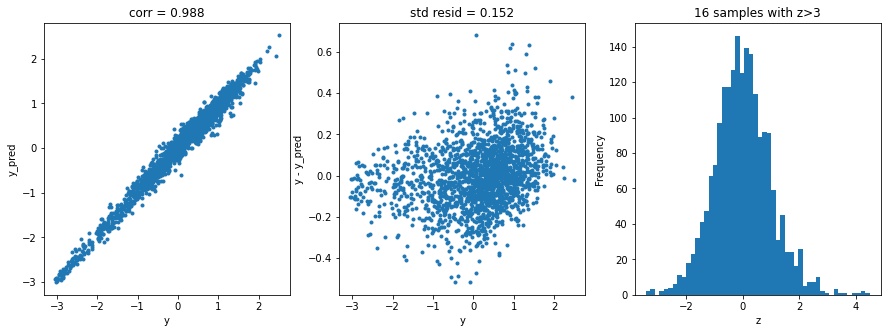

In [26]:
# GBDT
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[150,250,350],
              'max_depth':[1,2,3],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[19:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[19:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is 

[19:23:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.3min finished


[19:23:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------
XGBRegressor(max_depth=2, n_estimators=500)
----------------------
score= 0.9583327129991119
rmse= 0.20226099762614302
mse= 0.04090951116072265
cross_val: mean= 0.09829640578246059 , std= 0.005081757535848478


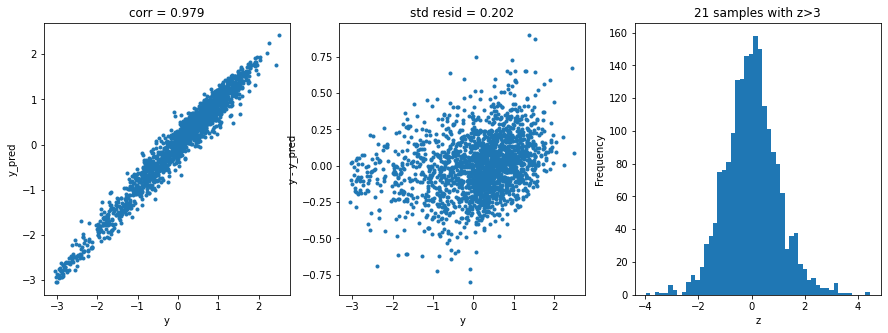

In [27]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  8.8min finished


----------------------
RandomForestRegressor(max_features=12, min_samples_split=6, n_estimators=200)
----------------------
score= 0.9796591307244757
rmse= 0.14131858731134334
mse= 0.019970943119673828
cross_val: mean= 0.10207280790169541 , std= 0.00938399130975788


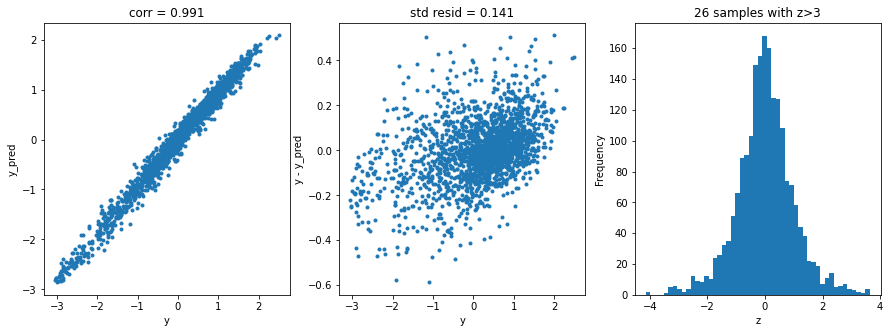

In [28]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[8,12,16,20,24],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

In [32]:
# 模型预测
def model_predict(test_data,test_y=[],stack=False):
    #poly_trans=PolynomialFeatures(degree=2)
    #test_data1=poly_trans.fit_transform(test_data)
    #test_data=MinMaxScaler().fit_transform(test_data)
    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model!="LinearSVR" and model!="KNeighbors":
            y_predict=opt_models[model].predict(test_data)
#             y_predict_total+=y_predict
            i+=1
        if len(test_y)>0:
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,3)
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        return y_predict_mean

In [33]:
# bagging预测
model_predict(X_valid,y_valid)

Ridge_mse: 0.13767187912783213
Lasso_mse: 0.13786142880041372
ElasticNet_mse: 0.13782685572640616
LinearSVR_mse: 0.13782685572640616
KNeighbors_mse: 0.13782685572640616
GradientBoosting_mse: 0.13268440436447884
XGB_mse: 0.13462044939362203
RandomForest_mse: 0.1399917429120826
mean_mse: 0.9466663344867359


In [ ]:
models = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'ElasticNet',
              'LinearSVR'],
    'Score': [Ridge,acc_KNeighborsRegressor,acc_RandomForestRegressor,acc_lightGbm]})
models.sort_values(by='Score', ascending=True)


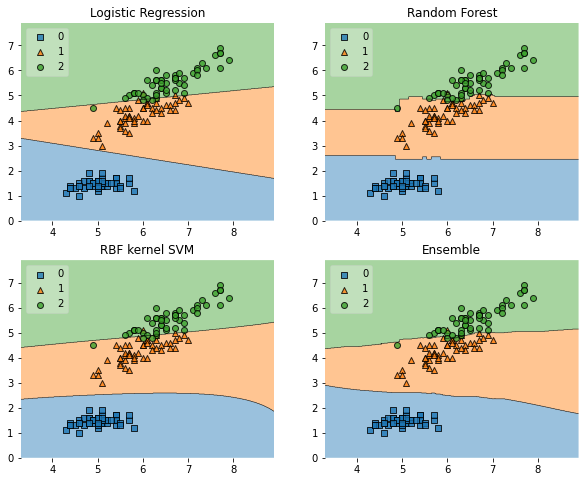

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##主要使用pip install mlxtend安装mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy import sparse
import xgboost
import lightgbm

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def stacking_reg(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):
    train=np.zeros((train_x.shape[0],1))
    test=np.zeros((test_x.shape[0],1))
    test_pre=np.empty((folds,test_x.shape[0],1))
    cv_scores=[]
    for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):       
        tr_x=train_x[train_index]
        tr_y=train_y[train_index]
        te_x=train_x[test_index]
        te_y = train_y[test_index]
        if clf_name in ["rf","ada","gb","et","lr","lsvc","knn"]:
            clf.fit(tr_x,tr_y)
            pre=clf.predict(te_x).reshape(-1,1)
            train[test_index]=pre
            test_pre[i,:]=clf.predict(test_x).reshape(-1,1)
            cv_scores.append(mean_squared_error(te_y, pre))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x, label=te_y, missing=-1)
            params = {'booster': 'gbtree',
                      'eval_metric': 'rmse',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12
                      }
            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'),
                         (test_matrix, 'eval')
                         ]
            if test_matrix:
                model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(test_matrix,ntree_limit=model.best_ntree_limit).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(z, ntree_limit=model.best_ntree_limit).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))

        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            #z = clf.Dataset(test_x, label=te_y)
            #z=test_x
            params = {
                      'boosting_type': 'gbdt',
                      'objective': 'regression_l2',
                      'metric': 'mse',
                      'min_child_weight': 1.5,
                      'num_leaves': 2**5,
                      'lambda_l2': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'learning_rate': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12,
                      'silent': True,
                      }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(te_x,num_iteration=model.best_iteration).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(test_x, num_iteration=model.best_iteration).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:"%clf_name,cv_scores)
    test[:]=test_pre.mean(axis=0)
    print("%s_score_list:"%clf_name,cv_scores)
    print("%s_score_mean:"%clf_name,np.mean(cv_scores))
    return train.reshape(-1,1),test.reshape(-1,1)

In [37]:
def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
    rf_train, rf_test = stacking_reg(randomforest, x_train, y_train, x_valid, "rf", kf, label_split=label_split)
    return rf_train, rf_test,"rf_reg"

def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
    ada_train, ada_test = stacking_reg(adaboost, x_train, y_train, x_valid, "ada", kf, label_split=label_split)
    return ada_train, ada_test,"ada_reg"

def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
    gbdt_train, gbdt_test = stacking_reg(gbdt, x_train, y_train, x_valid, "gb", kf, label_split=label_split)
    return gbdt_train, gbdt_test,"gb_reg"

def et_reg(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
    et_train, et_test = stacking_reg(extratree, x_train, y_train, x_valid, "et", kf, label_split=label_split)
    return et_train, et_test,"et_reg"

def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
    lr_reg=LinearRegression(n_jobs=-1)
    lr_train, lr_test = stacking_reg(lr_reg, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return lr_train, lr_test, "lr_reg"

def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_reg(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"xgb_reg"

def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    lgb_train, lgb_test = stacking_reg(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split=label_split)
    return lgb_train, lgb_test,"lgb_reg"

In [38]:
def stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split=None, clf_fin="lgb", if_concat_origin=True):
    for k, clf_list in enumerate(clf_list):
        clf_list = [clf_list]
        column_list = []
        train_data_list=[]
        test_data_list=[]
        for clf in clf_list:
            train_data,test_data,clf_name=clf(x_train, y_train, x_valid, kf, label_split=label_split)
            train_data_list.append(train_data)
            test_data_list.append(test_data)
            column_list.append("clf_%s" % (clf_name))
    train = np.concatenate(train_data_list, axis=1)
    test = np.concatenate(test_data_list, axis=1)
    
    if if_concat_origin:
        train = np.concatenate([x_train, train], axis=1)
        test = np.concatenate([x_valid, test], axis=1)
    print(x_train.shape)
    print(train.shape)
    print(clf_name)
    print(clf_name in ["lgb"])
    if clf_fin in ["rf","ada","gb","et","lr","lsvc","knn"]:
        if clf_fin in ["rf"]:
            clf = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
        elif clf_fin in ["ada"]:
            clf = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
        elif clf_fin in ["gb"]:
            clf = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
        elif clf_fin in ["et"]:
            clf = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
        elif clf_fin in ["lr"]:
            clf = LinearRegression(n_jobs=-1)
        clf.fit(train, y_train)
        pre = clf.predict(test).reshape(-1,1)
        return pred
    elif clf_fin in ["xgb"]:
        clf = xgboost
        train_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        test_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        params = {'booster': 'gbtree',
                  'eval_metric': 'rmse',
                  'gamma': 1,
                  'min_child_weight': 1.5,
                  'max_depth': 5,
                  'lambda': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'eta': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12
                  }
        num_round = 10000
        early_stopping_rounds = 100
        watchlist = [(train_matrix, 'train'),
                     (test_matrix, 'eval')
                     ]
        model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                          early_stopping_rounds=early_stopping_rounds
                          )
        pre = model.predict(test,ntree_limit=model.best_ntree_limit).reshape(-1,1)
        return pre
    elif clf_fin in ["lgb"]:
        print(clf_name)
        clf = lightgbm
        train_matrix = clf.Dataset(train, label=y_train)
        test_matrix = clf.Dataset(train, label=y_train)
        params = {
                  'boosting_type': 'gbdt',
                  'objective': 'regression_l2',
                  'metric': 'mse',
                  'min_child_weight': 1.5,
                  'num_leaves': 2**5,
                  'lambda_l2': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'learning_rate': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12,
                  'silent': True,
                  }
        num_round = 10000
        early_stopping_rounds = 100
        model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                          early_stopping_rounds=early_stopping_rounds
                          )
        print('pred')
        pre = model.predict(test,num_iteration=model.best_iteration).reshape(-1,1)
        print(pre)
        return pre

In [39]:
# #load_dataset
with open("./zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")

In [40]:
from sklearn.model_selection import StratifiedKFold, KFold

folds = 5
seed = 1
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [41]:
x_train = data_train[data_test.columns].values
x_valid = data_test[data_test.columns].values
y_train = data_train['target'].values

In [42]:
clf_list = [lr_reg, lgb_reg]
#clf_list = [lr_reg, rf_reg]

##很容易过拟合
pred = stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split=None, clf_fin="lgb", if_concat_origin=True)

lr now score is: [0.11573216950871246]
lr now score is: [0.11573216950871246, 0.09417486426618935]
lr now score is: [0.11573216950871246, 0.09417486426618935, 0.10805046561851064]
lr now score is: [0.11573216950871246, 0.09417486426618935, 0.10805046561851064, 0.1242088706560156]
lr now score is: [0.11573216950871246, 0.09417486426618935, 0.10805046561851064, 0.1242088706560156, 0.11940113841914]
lr_score_list: [0.11573216950871246, 0.09417486426618935, 0.10805046561851064, 0.1242088706560156, 0.11940113841914]
lr_score_mean: 0.11231350169371361
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise

[261]	valid_0's l2: 0.117504
[262]	valid_0's l2: 0.117394
[263]	valid_0's l2: 0.117426
[264]	valid_0's l2: 0.117393
[265]	valid_0's l2: 0.117334
[266]	valid_0's l2: 0.117273
[267]	valid_0's l2: 0.117258
[268]	valid_0's l2: 0.117163
[269]	valid_0's l2: 0.117064
[270]	valid_0's l2: 0.117054
[271]	valid_0's l2: 0.116993
[272]	valid_0's l2: 0.116947
[273]	valid_0's l2: 0.116938
[274]	valid_0's l2: 0.11687
[275]	valid_0's l2: 0.116836
[276]	valid_0's l2: 0.116819
[277]	valid_0's l2: 0.116712
[278]	valid_0's l2: 0.116708
[279]	valid_0's l2: 0.116678
[280]	valid_0's l2: 0.116601
[281]	valid_0's l2: 0.116624
[282]	valid_0's l2: 0.116609
[283]	valid_0's l2: 0.116566
[284]	valid_0's l2: 0.116513
[285]	valid_0's l2: 0.116429
[286]	valid_0's l2: 0.116397
[287]	valid_0's l2: 0.116341
[288]	valid_0's l2: 0.116352
[289]	valid_0's l2: 0.116273
[290]	valid_0's l2: 0.116209
[291]	valid_0's l2: 0.116211
[292]	valid_0's l2: 0.116152
[293]	valid_0's l2: 0.116054
[294]	valid_0's l2: 0.116108
[295]	valid_0's

[548]	valid_0's l2: 0.112845
[549]	valid_0's l2: 0.112851
[550]	valid_0's l2: 0.112844
[551]	valid_0's l2: 0.112882
[552]	valid_0's l2: 0.112858
[553]	valid_0's l2: 0.112832
[554]	valid_0's l2: 0.11282
[555]	valid_0's l2: 0.112799
[556]	valid_0's l2: 0.11278
[557]	valid_0's l2: 0.112739
[558]	valid_0's l2: 0.112778
[559]	valid_0's l2: 0.112759
[560]	valid_0's l2: 0.112743
[561]	valid_0's l2: 0.112745
[562]	valid_0's l2: 0.112727
[563]	valid_0's l2: 0.112682
[564]	valid_0's l2: 0.112642
[565]	valid_0's l2: 0.112618
[566]	valid_0's l2: 0.112574
[567]	valid_0's l2: 0.112582
[568]	valid_0's l2: 0.112595
[569]	valid_0's l2: 0.11258
[570]	valid_0's l2: 0.112562
[571]	valid_0's l2: 0.112559
[572]	valid_0's l2: 0.112525
[573]	valid_0's l2: 0.112537
[574]	valid_0's l2: 0.112517
[575]	valid_0's l2: 0.112506
[576]	valid_0's l2: 0.112471
[577]	valid_0's l2: 0.112491
[578]	valid_0's l2: 0.112496
[579]	valid_0's l2: 0.112471
[580]	valid_0's l2: 0.112469
[581]	valid_0's l2: 0.112439
[582]	valid_0's l

[842]	valid_0's l2: 0.111293
[843]	valid_0's l2: 0.111286
[844]	valid_0's l2: 0.111277
[845]	valid_0's l2: 0.111263
[846]	valid_0's l2: 0.111251
[847]	valid_0's l2: 0.111252
[848]	valid_0's l2: 0.111233
[849]	valid_0's l2: 0.111232
[850]	valid_0's l2: 0.111223
[851]	valid_0's l2: 0.111229
[852]	valid_0's l2: 0.111229
[853]	valid_0's l2: 0.111221
[854]	valid_0's l2: 0.111235
[855]	valid_0's l2: 0.111226
[856]	valid_0's l2: 0.111231
[857]	valid_0's l2: 0.111222
[858]	valid_0's l2: 0.111212
[859]	valid_0's l2: 0.111206
[860]	valid_0's l2: 0.111203
[861]	valid_0's l2: 0.111206
[862]	valid_0's l2: 0.111195
[863]	valid_0's l2: 0.111187
[864]	valid_0's l2: 0.111181
[865]	valid_0's l2: 0.111182
[866]	valid_0's l2: 0.111195
[867]	valid_0's l2: 0.111168
[868]	valid_0's l2: 0.111173
[869]	valid_0's l2: 0.111178
[870]	valid_0's l2: 0.111174
[871]	valid_0's l2: 0.111162
[872]	valid_0's l2: 0.111173
[873]	valid_0's l2: 0.111155
[874]	valid_0's l2: 0.111149
[875]	valid_0's l2: 0.111144
[876]	valid_0'

[1122]	valid_0's l2: 0.11059
[1123]	valid_0's l2: 0.110587
[1124]	valid_0's l2: 0.110583
[1125]	valid_0's l2: 0.110583
[1126]	valid_0's l2: 0.110583
[1127]	valid_0's l2: 0.110586
[1128]	valid_0's l2: 0.110592
[1129]	valid_0's l2: 0.110591
[1130]	valid_0's l2: 0.110587
[1131]	valid_0's l2: 0.110584
[1132]	valid_0's l2: 0.110582
[1133]	valid_0's l2: 0.110584
[1134]	valid_0's l2: 0.110575
[1135]	valid_0's l2: 0.110569
[1136]	valid_0's l2: 0.110576
[1137]	valid_0's l2: 0.110589
[1138]	valid_0's l2: 0.110596
[1139]	valid_0's l2: 0.110594
[1140]	valid_0's l2: 0.110592
[1141]	valid_0's l2: 0.110596
[1142]	valid_0's l2: 0.110594
[1143]	valid_0's l2: 0.110593
[1144]	valid_0's l2: 0.11059
[1145]	valid_0's l2: 0.110595
[1146]	valid_0's l2: 0.110597
[1147]	valid_0's l2: 0.110597
[1148]	valid_0's l2: 0.110609
[1149]	valid_0's l2: 0.110608
[1150]	valid_0's l2: 0.110599
[1151]	valid_0's l2: 0.110602
[1152]	valid_0's l2: 0.110601
[1153]	valid_0's l2: 0.11059
[1154]	valid_0's l2: 0.110583
[1155]	valid_

[1403]	valid_0's l2: 0.110309
[1404]	valid_0's l2: 0.110311
[1405]	valid_0's l2: 0.110311
[1406]	valid_0's l2: 0.110312
[1407]	valid_0's l2: 0.110313
[1408]	valid_0's l2: 0.110305
[1409]	valid_0's l2: 0.110301
[1410]	valid_0's l2: 0.110302
[1411]	valid_0's l2: 0.110302
[1412]	valid_0's l2: 0.1103
[1413]	valid_0's l2: 0.110299
[1414]	valid_0's l2: 0.110296
[1415]	valid_0's l2: 0.110294
[1416]	valid_0's l2: 0.110296
[1417]	valid_0's l2: 0.110296
[1418]	valid_0's l2: 0.110295
[1419]	valid_0's l2: 0.110293
[1420]	valid_0's l2: 0.110294
[1421]	valid_0's l2: 0.110298
[1422]	valid_0's l2: 0.110299
[1423]	valid_0's l2: 0.110298
[1424]	valid_0's l2: 0.110298
[1425]	valid_0's l2: 0.110306
[1426]	valid_0's l2: 0.110304
[1427]	valid_0's l2: 0.110303
[1428]	valid_0's l2: 0.110306
[1429]	valid_0's l2: 0.110305
[1430]	valid_0's l2: 0.11031
[1431]	valid_0's l2: 0.11031
[1432]	valid_0's l2: 0.110313
[1433]	valid_0's l2: 0.110314
[1434]	valid_0's l2: 0.110306
[1435]	valid_0's l2: 0.110309
[1436]	valid_0

[46]	valid_0's l2: 0.18864
[47]	valid_0's l2: 0.185191
[48]	valid_0's l2: 0.181781
[49]	valid_0's l2: 0.178617
[50]	valid_0's l2: 0.17564
[51]	valid_0's l2: 0.17263
[52]	valid_0's l2: 0.170023
[53]	valid_0's l2: 0.167523
[54]	valid_0's l2: 0.16511
[55]	valid_0's l2: 0.162756
[56]	valid_0's l2: 0.160283
[57]	valid_0's l2: 0.158385
[58]	valid_0's l2: 0.156343
[59]	valid_0's l2: 0.154427
[60]	valid_0's l2: 0.152609
[61]	valid_0's l2: 0.150822
[62]	valid_0's l2: 0.148894
[63]	valid_0's l2: 0.147392
[64]	valid_0's l2: 0.145769
[65]	valid_0's l2: 0.14409
[66]	valid_0's l2: 0.142545
[67]	valid_0's l2: 0.141187
[68]	valid_0's l2: 0.139822
[69]	valid_0's l2: 0.138396
[70]	valid_0's l2: 0.137236
[71]	valid_0's l2: 0.136107
[72]	valid_0's l2: 0.135055
[73]	valid_0's l2: 0.133874
[74]	valid_0's l2: 0.132889
[75]	valid_0's l2: 0.131947
[76]	valid_0's l2: 0.131061
[77]	valid_0's l2: 0.130208
[78]	valid_0's l2: 0.12939
[79]	valid_0's l2: 0.128622
[80]	valid_0's l2: 0.127771
[81]	valid_0's l2: 0.12690

[343]	valid_0's l2: 0.0988929
[344]	valid_0's l2: 0.0988898
[345]	valid_0's l2: 0.0988565
[346]	valid_0's l2: 0.098843
[347]	valid_0's l2: 0.0988043
[348]	valid_0's l2: 0.0988476
[349]	valid_0's l2: 0.0988087
[350]	valid_0's l2: 0.0987613
[351]	valid_0's l2: 0.0987818
[352]	valid_0's l2: 0.0987872
[353]	valid_0's l2: 0.0987914
[354]	valid_0's l2: 0.0987412
[355]	valid_0's l2: 0.0986845
[356]	valid_0's l2: 0.0986821
[357]	valid_0's l2: 0.098661
[358]	valid_0's l2: 0.0986718
[359]	valid_0's l2: 0.0986177
[360]	valid_0's l2: 0.0985925
[361]	valid_0's l2: 0.0985983
[362]	valid_0's l2: 0.0985937
[363]	valid_0's l2: 0.0985823
[364]	valid_0's l2: 0.0985532
[365]	valid_0's l2: 0.0985281
[366]	valid_0's l2: 0.0985264
[367]	valid_0's l2: 0.0985262
[368]	valid_0's l2: 0.0985292
[369]	valid_0's l2: 0.0984899
[370]	valid_0's l2: 0.0985204
[371]	valid_0's l2: 0.0985089
[372]	valid_0's l2: 0.0985238
[373]	valid_0's l2: 0.0985242
[374]	valid_0's l2: 0.0985139
[375]	valid_0's l2: 0.098574
[376]	valid_0

[627]	valid_0's l2: 0.0968205
[628]	valid_0's l2: 0.0968068
[629]	valid_0's l2: 0.0968003
[630]	valid_0's l2: 0.0967876
[631]	valid_0's l2: 0.096795
[632]	valid_0's l2: 0.0967954
[633]	valid_0's l2: 0.0967953
[634]	valid_0's l2: 0.0967924
[635]	valid_0's l2: 0.0968046
[636]	valid_0's l2: 0.0968013
[637]	valid_0's l2: 0.0967799
[638]	valid_0's l2: 0.0967724
[639]	valid_0's l2: 0.0967488
[640]	valid_0's l2: 0.0967485
[641]	valid_0's l2: 0.0967386
[642]	valid_0's l2: 0.0967147
[643]	valid_0's l2: 0.0967007
[644]	valid_0's l2: 0.0966987
[645]	valid_0's l2: 0.0966905
[646]	valid_0's l2: 0.0966842
[647]	valid_0's l2: 0.0966888
[648]	valid_0's l2: 0.0966861
[649]	valid_0's l2: 0.0967027
[650]	valid_0's l2: 0.0967233
[651]	valid_0's l2: 0.0967289
[652]	valid_0's l2: 0.0967084
[653]	valid_0's l2: 0.0966973
[654]	valid_0's l2: 0.0966853
[655]	valid_0's l2: 0.0966667
[656]	valid_0's l2: 0.0966574
[657]	valid_0's l2: 0.0966491
[658]	valid_0's l2: 0.0966371
[659]	valid_0's l2: 0.0966187
[660]	valid

[909]	valid_0's l2: 0.0960609
[910]	valid_0's l2: 0.0960761
[911]	valid_0's l2: 0.0960784
[912]	valid_0's l2: 0.0960526
[913]	valid_0's l2: 0.0960641
[914]	valid_0's l2: 0.0960551
[915]	valid_0's l2: 0.0960731
[916]	valid_0's l2: 0.0960859
[917]	valid_0's l2: 0.0960757
[918]	valid_0's l2: 0.0960577
[919]	valid_0's l2: 0.096062
[920]	valid_0's l2: 0.0960588
[921]	valid_0's l2: 0.09608
[922]	valid_0's l2: 0.0960862
[923]	valid_0's l2: 0.0960929
[924]	valid_0's l2: 0.096087
[925]	valid_0's l2: 0.0960833
[926]	valid_0's l2: 0.0960688
[927]	valid_0's l2: 0.0960668
[928]	valid_0's l2: 0.0960619
[929]	valid_0's l2: 0.0960548
[930]	valid_0's l2: 0.0960545
[931]	valid_0's l2: 0.0960563
[932]	valid_0's l2: 0.0960489
[933]	valid_0's l2: 0.0960588
[934]	valid_0's l2: 0.0960784
[935]	valid_0's l2: 0.0960696
[936]	valid_0's l2: 0.0960794
[937]	valid_0's l2: 0.0960831
[938]	valid_0's l2: 0.0960731
[939]	valid_0's l2: 0.096068
[940]	valid_0's l2: 0.0960698
[941]	valid_0's l2: 0.0960685
[942]	valid_0's

[20]	valid_0's l2: 0.411839
[21]	valid_0's l2: 0.396345
[22]	valid_0's l2: 0.382314
[23]	valid_0's l2: 0.368991
[24]	valid_0's l2: 0.356666
[25]	valid_0's l2: 0.344728
[26]	valid_0's l2: 0.332818
[27]	valid_0's l2: 0.322327
[28]	valid_0's l2: 0.312361
[29]	valid_0's l2: 0.302618
[30]	valid_0's l2: 0.293583
[31]	valid_0's l2: 0.284772
[32]	valid_0's l2: 0.27643
[33]	valid_0's l2: 0.268242
[34]	valid_0's l2: 0.260699
[35]	valid_0's l2: 0.25392
[36]	valid_0's l2: 0.247676
[37]	valid_0's l2: 0.241242
[38]	valid_0's l2: 0.235133
[39]	valid_0's l2: 0.229733
[40]	valid_0's l2: 0.224359
[41]	valid_0's l2: 0.219506
[42]	valid_0's l2: 0.214509
[43]	valid_0's l2: 0.210222
[44]	valid_0's l2: 0.205951
[45]	valid_0's l2: 0.201601
[46]	valid_0's l2: 0.197821
[47]	valid_0's l2: 0.193874
[48]	valid_0's l2: 0.190225
[49]	valid_0's l2: 0.1869
[50]	valid_0's l2: 0.183644
[51]	valid_0's l2: 0.180409
[52]	valid_0's l2: 0.177691
[53]	valid_0's l2: 0.174935
[54]	valid_0's l2: 0.172226
[55]	valid_0's l2: 0.169

[310]	valid_0's l2: 0.102916
[311]	valid_0's l2: 0.102901
[312]	valid_0's l2: 0.10285
[313]	valid_0's l2: 0.102885
[314]	valid_0's l2: 0.102853
[315]	valid_0's l2: 0.102858
[316]	valid_0's l2: 0.102871
[317]	valid_0's l2: 0.102798
[318]	valid_0's l2: 0.102791
[319]	valid_0's l2: 0.102736
[320]	valid_0's l2: 0.102734
[321]	valid_0's l2: 0.102737
[322]	valid_0's l2: 0.102741
[323]	valid_0's l2: 0.1027
[324]	valid_0's l2: 0.102697
[325]	valid_0's l2: 0.102658
[326]	valid_0's l2: 0.102585
[327]	valid_0's l2: 0.102608
[328]	valid_0's l2: 0.102563
[329]	valid_0's l2: 0.102513
[330]	valid_0's l2: 0.102446
[331]	valid_0's l2: 0.102381
[332]	valid_0's l2: 0.102331
[333]	valid_0's l2: 0.102308
[334]	valid_0's l2: 0.102315
[335]	valid_0's l2: 0.102298
[336]	valid_0's l2: 0.102296
[337]	valid_0's l2: 0.10226
[338]	valid_0's l2: 0.102239
[339]	valid_0's l2: 0.102201
[340]	valid_0's l2: 0.102196
[341]	valid_0's l2: 0.102281
[342]	valid_0's l2: 0.102277
[343]	valid_0's l2: 0.102277
[344]	valid_0's l2

[602]	valid_0's l2: 0.100858
[603]	valid_0's l2: 0.100868
[604]	valid_0's l2: 0.100859
[605]	valid_0's l2: 0.100866
[606]	valid_0's l2: 0.100863
[607]	valid_0's l2: 0.100893
[608]	valid_0's l2: 0.100868
[609]	valid_0's l2: 0.100861
[610]	valid_0's l2: 0.10086
[611]	valid_0's l2: 0.100853
[612]	valid_0's l2: 0.100868
[613]	valid_0's l2: 0.100873
[614]	valid_0's l2: 0.100863
[615]	valid_0's l2: 0.10089
[616]	valid_0's l2: 0.100886
[617]	valid_0's l2: 0.100913
[618]	valid_0's l2: 0.100911
[619]	valid_0's l2: 0.100923
[620]	valid_0's l2: 0.100909
[621]	valid_0's l2: 0.100905
[622]	valid_0's l2: 0.100911
[623]	valid_0's l2: 0.100944
[624]	valid_0's l2: 0.100927
[625]	valid_0's l2: 0.100944
[626]	valid_0's l2: 0.100951
[627]	valid_0's l2: 0.100947
[628]	valid_0's l2: 0.100952
[629]	valid_0's l2: 0.100929
[630]	valid_0's l2: 0.100931
[631]	valid_0's l2: 0.100922
[632]	valid_0's l2: 0.100914
[633]	valid_0's l2: 0.100918
[634]	valid_0's l2: 0.100949
[635]	valid_0's l2: 0.100957
[636]	valid_0's 

[195]	valid_0's l2: 0.120443
[196]	valid_0's l2: 0.120366
[197]	valid_0's l2: 0.120223
[198]	valid_0's l2: 0.120173
[199]	valid_0's l2: 0.120144
[200]	valid_0's l2: 0.120074
[201]	valid_0's l2: 0.120014
[202]	valid_0's l2: 0.119923
[203]	valid_0's l2: 0.119829
[204]	valid_0's l2: 0.119771
[205]	valid_0's l2: 0.119675
[206]	valid_0's l2: 0.11956
[207]	valid_0's l2: 0.119615
[208]	valid_0's l2: 0.119598
[209]	valid_0's l2: 0.119612
[210]	valid_0's l2: 0.119571
[211]	valid_0's l2: 0.119534
[212]	valid_0's l2: 0.119483
[213]	valid_0's l2: 0.119477
[214]	valid_0's l2: 0.119439
[215]	valid_0's l2: 0.119413
[216]	valid_0's l2: 0.119368
[217]	valid_0's l2: 0.119304
[218]	valid_0's l2: 0.119201
[219]	valid_0's l2: 0.119133
[220]	valid_0's l2: 0.119044
[221]	valid_0's l2: 0.11902
[222]	valid_0's l2: 0.118855
[223]	valid_0's l2: 0.118823
[224]	valid_0's l2: 0.118805
[225]	valid_0's l2: 0.118776
[226]	valid_0's l2: 0.118777
[227]	valid_0's l2: 0.118727
[228]	valid_0's l2: 0.118676
[229]	valid_0's 

[485]	valid_0's l2: 0.114199
[486]	valid_0's l2: 0.114198
[487]	valid_0's l2: 0.114239
[488]	valid_0's l2: 0.114201
[489]	valid_0's l2: 0.114159
[490]	valid_0's l2: 0.114162
[491]	valid_0's l2: 0.114171
[492]	valid_0's l2: 0.114114
[493]	valid_0's l2: 0.114095
[494]	valid_0's l2: 0.114072
[495]	valid_0's l2: 0.114071
[496]	valid_0's l2: 0.114057
[497]	valid_0's l2: 0.114037
[498]	valid_0's l2: 0.114075
[499]	valid_0's l2: 0.114103
[500]	valid_0's l2: 0.114088
[501]	valid_0's l2: 0.114034
[502]	valid_0's l2: 0.114035
[503]	valid_0's l2: 0.114034
[504]	valid_0's l2: 0.114012
[505]	valid_0's l2: 0.114022
[506]	valid_0's l2: 0.11399
[507]	valid_0's l2: 0.114028
[508]	valid_0's l2: 0.114007
[509]	valid_0's l2: 0.114008
[510]	valid_0's l2: 0.114026
[511]	valid_0's l2: 0.114011
[512]	valid_0's l2: 0.114009
[513]	valid_0's l2: 0.113986
[514]	valid_0's l2: 0.113997
[515]	valid_0's l2: 0.114011
[516]	valid_0's l2: 0.113998
[517]	valid_0's l2: 0.113996
[518]	valid_0's l2: 0.114001
[519]	valid_0's

[783]	valid_0's l2: 0.113217
[784]	valid_0's l2: 0.113218
[785]	valid_0's l2: 0.11321
[786]	valid_0's l2: 0.113211
[787]	valid_0's l2: 0.113207
[788]	valid_0's l2: 0.113214
[789]	valid_0's l2: 0.113206
[790]	valid_0's l2: 0.113194
[791]	valid_0's l2: 0.113212
[792]	valid_0's l2: 0.113223
[793]	valid_0's l2: 0.113207
[794]	valid_0's l2: 0.113192
[795]	valid_0's l2: 0.113184
[796]	valid_0's l2: 0.113191
[797]	valid_0's l2: 0.113179
[798]	valid_0's l2: 0.113172
[799]	valid_0's l2: 0.11317
[800]	valid_0's l2: 0.113183
[801]	valid_0's l2: 0.113199
[802]	valid_0's l2: 0.113197
[803]	valid_0's l2: 0.113188
[804]	valid_0's l2: 0.113197
[805]	valid_0's l2: 0.113196
[806]	valid_0's l2: 0.113202
[807]	valid_0's l2: 0.113189
[808]	valid_0's l2: 0.113174
[809]	valid_0's l2: 0.113167
[810]	valid_0's l2: 0.113139
[811]	valid_0's l2: 0.113154
[812]	valid_0's l2: 0.113148
[813]	valid_0's l2: 0.113146
[814]	valid_0's l2: 0.113135
[815]	valid_0's l2: 0.113145
[816]	valid_0's l2: 0.113158
[817]	valid_0's 

[63]	valid_0's l2: 0.166429
[64]	valid_0's l2: 0.16444
[65]	valid_0's l2: 0.162641
[66]	valid_0's l2: 0.16089
[67]	valid_0's l2: 0.15942
[68]	valid_0's l2: 0.157732
[69]	valid_0's l2: 0.156235
[70]	valid_0's l2: 0.154809
[71]	valid_0's l2: 0.153308
[72]	valid_0's l2: 0.151879
[73]	valid_0's l2: 0.150654
[74]	valid_0's l2: 0.149304
[75]	valid_0's l2: 0.148061
[76]	valid_0's l2: 0.146904
[77]	valid_0's l2: 0.145824
[78]	valid_0's l2: 0.144673
[79]	valid_0's l2: 0.143632
[80]	valid_0's l2: 0.142637
[81]	valid_0's l2: 0.141813
[82]	valid_0's l2: 0.140874
[83]	valid_0's l2: 0.140128
[84]	valid_0's l2: 0.139218
[85]	valid_0's l2: 0.13836
[86]	valid_0's l2: 0.137665
[87]	valid_0's l2: 0.136774
[88]	valid_0's l2: 0.136091
[89]	valid_0's l2: 0.135301
[90]	valid_0's l2: 0.134483
[91]	valid_0's l2: 0.133781
[92]	valid_0's l2: 0.133191
[93]	valid_0's l2: 0.132801
[94]	valid_0's l2: 0.132071
[95]	valid_0's l2: 0.131386
[96]	valid_0's l2: 0.13081
[97]	valid_0's l2: 0.130295
[98]	valid_0's l2: 0.1298

[363]	valid_0's l2: 0.106369
[364]	valid_0's l2: 0.106313
[365]	valid_0's l2: 0.106313
[366]	valid_0's l2: 0.106346
[367]	valid_0's l2: 0.106319
[368]	valid_0's l2: 0.106254
[369]	valid_0's l2: 0.106227
[370]	valid_0's l2: 0.106221
[371]	valid_0's l2: 0.106206
[372]	valid_0's l2: 0.10623
[373]	valid_0's l2: 0.106241
[374]	valid_0's l2: 0.106209
[375]	valid_0's l2: 0.106188
[376]	valid_0's l2: 0.106152
[377]	valid_0's l2: 0.10616
[378]	valid_0's l2: 0.106174
[379]	valid_0's l2: 0.106153
[380]	valid_0's l2: 0.106127
[381]	valid_0's l2: 0.106149
[382]	valid_0's l2: 0.106143
[383]	valid_0's l2: 0.106085
[384]	valid_0's l2: 0.106092
[385]	valid_0's l2: 0.106045
[386]	valid_0's l2: 0.106038
[387]	valid_0's l2: 0.106077
[388]	valid_0's l2: 0.106071
[389]	valid_0's l2: 0.106057
[390]	valid_0's l2: 0.106062
[391]	valid_0's l2: 0.10606
[392]	valid_0's l2: 0.106015
[393]	valid_0's l2: 0.10606
[394]	valid_0's l2: 0.106048
[395]	valid_0's l2: 0.10603
[396]	valid_0's l2: 0.106033
[397]	valid_0's l2:

[661]	valid_0's l2: 0.104776
[662]	valid_0's l2: 0.104776
[663]	valid_0's l2: 0.104782
[664]	valid_0's l2: 0.104785
[665]	valid_0's l2: 0.10478
[666]	valid_0's l2: 0.10479
[667]	valid_0's l2: 0.104755
[668]	valid_0's l2: 0.104739
[669]	valid_0's l2: 0.104728
[670]	valid_0's l2: 0.104752
[671]	valid_0's l2: 0.10476
[672]	valid_0's l2: 0.104744
[673]	valid_0's l2: 0.104738
[674]	valid_0's l2: 0.104721
[675]	valid_0's l2: 0.104714
[676]	valid_0's l2: 0.104719
[677]	valid_0's l2: 0.104749
[678]	valid_0's l2: 0.10473
[679]	valid_0's l2: 0.104761
[680]	valid_0's l2: 0.104756
[681]	valid_0's l2: 0.10477
[682]	valid_0's l2: 0.10477
[683]	valid_0's l2: 0.104768
[684]	valid_0's l2: 0.104767
[685]	valid_0's l2: 0.104801
[686]	valid_0's l2: 0.104784
[687]	valid_0's l2: 0.104798
[688]	valid_0's l2: 0.104798
[689]	valid_0's l2: 0.104791
[690]	valid_0's l2: 0.104781
[691]	valid_0's l2: 0.104767
[692]	valid_0's l2: 0.104759
[693]	valid_0's l2: 0.104757
[694]	valid_0's l2: 0.10475
[695]	valid_0's l2: 0

[960]	valid_0's l2: 0.104251
[961]	valid_0's l2: 0.10425
[962]	valid_0's l2: 0.104246
[963]	valid_0's l2: 0.104245
[964]	valid_0's l2: 0.104253
[965]	valid_0's l2: 0.104256
[966]	valid_0's l2: 0.104252
[967]	valid_0's l2: 0.104278
[968]	valid_0's l2: 0.10427
[969]	valid_0's l2: 0.10426
[970]	valid_0's l2: 0.104264
[971]	valid_0's l2: 0.104261
[972]	valid_0's l2: 0.104257
[973]	valid_0's l2: 0.104258
[974]	valid_0's l2: 0.104245
[975]	valid_0's l2: 0.104239
[976]	valid_0's l2: 0.104222
[977]	valid_0's l2: 0.104226
[978]	valid_0's l2: 0.104224
[979]	valid_0's l2: 0.104231
[980]	valid_0's l2: 0.104222
[981]	valid_0's l2: 0.104224
[982]	valid_0's l2: 0.104216
[983]	valid_0's l2: 0.1042
[984]	valid_0's l2: 0.104202
[985]	valid_0's l2: 0.104208
[986]	valid_0's l2: 0.1042
[987]	valid_0's l2: 0.104191
[988]	valid_0's l2: 0.104193
[989]	valid_0's l2: 0.104189
[990]	valid_0's l2: 0.104192
[991]	valid_0's l2: 0.104189
[992]	valid_0's l2: 0.104189
[993]	valid_0's l2: 0.104195
[994]	valid_0's l2: 0

[1238]	valid_0's l2: 0.103994
[1239]	valid_0's l2: 0.104003
[1240]	valid_0's l2: 0.104
[1241]	valid_0's l2: 0.104005
[1242]	valid_0's l2: 0.104004
[1243]	valid_0's l2: 0.104001
[1244]	valid_0's l2: 0.104011
[1245]	valid_0's l2: 0.104
[1246]	valid_0's l2: 0.104003
[1247]	valid_0's l2: 0.104002
[1248]	valid_0's l2: 0.104005
[1249]	valid_0's l2: 0.104009
[1250]	valid_0's l2: 0.104007
[1251]	valid_0's l2: 0.104003
[1252]	valid_0's l2: 0.104004
[1253]	valid_0's l2: 0.103993
[1254]	valid_0's l2: 0.103986
[1255]	valid_0's l2: 0.103973
[1256]	valid_0's l2: 0.103959
[1257]	valid_0's l2: 0.103958
[1258]	valid_0's l2: 0.103957
[1259]	valid_0's l2: 0.103962
[1260]	valid_0's l2: 0.103958
[1261]	valid_0's l2: 0.103953
[1262]	valid_0's l2: 0.103949
[1263]	valid_0's l2: 0.103952
[1264]	valid_0's l2: 0.10395
[1265]	valid_0's l2: 0.103944
[1266]	valid_0's l2: 0.103943
[1267]	valid_0's l2: 0.103942
[1268]	valid_0's l2: 0.103939
[1269]	valid_0's l2: 0.103939
[1270]	valid_0's l2: 0.103943
[1271]	valid_0's 

[1521]	valid_0's l2: 0.103817
[1522]	valid_0's l2: 0.103817
[1523]	valid_0's l2: 0.103816
[1524]	valid_0's l2: 0.103805
[1525]	valid_0's l2: 0.103805
[1526]	valid_0's l2: 0.103805
[1527]	valid_0's l2: 0.103803
[1528]	valid_0's l2: 0.103801
[1529]	valid_0's l2: 0.1038
[1530]	valid_0's l2: 0.1038
[1531]	valid_0's l2: 0.103799
[1532]	valid_0's l2: 0.103798
[1533]	valid_0's l2: 0.103801
[1534]	valid_0's l2: 0.103801
[1535]	valid_0's l2: 0.103799
[1536]	valid_0's l2: 0.103796
[1537]	valid_0's l2: 0.103799
[1538]	valid_0's l2: 0.103799
[1539]	valid_0's l2: 0.103798
[1540]	valid_0's l2: 0.103798
[1541]	valid_0's l2: 0.103798
[1542]	valid_0's l2: 0.103793
[1543]	valid_0's l2: 0.103792
[1544]	valid_0's l2: 0.103791
[1545]	valid_0's l2: 0.10379
[1546]	valid_0's l2: 0.103789
[1547]	valid_0's l2: 0.103795
[1548]	valid_0's l2: 0.1038
[1549]	valid_0's l2: 0.103797
[1550]	valid_0's l2: 0.103794
[1551]	valid_0's l2: 0.103795
[1552]	valid_0's l2: 0.103791
[1553]	valid_0's l2: 0.10379
[1554]	valid_0's l

[1805]	valid_0's l2: 0.103633
[1806]	valid_0's l2: 0.103634
[1807]	valid_0's l2: 0.103636
[1808]	valid_0's l2: 0.103635
[1809]	valid_0's l2: 0.103636
[1810]	valid_0's l2: 0.103635
[1811]	valid_0's l2: 0.103634
[1812]	valid_0's l2: 0.103634
[1813]	valid_0's l2: 0.103634
[1814]	valid_0's l2: 0.103634
[1815]	valid_0's l2: 0.103637
[1816]	valid_0's l2: 0.103637
[1817]	valid_0's l2: 0.103634
[1818]	valid_0's l2: 0.103634
[1819]	valid_0's l2: 0.103633
[1820]	valid_0's l2: 0.103632
[1821]	valid_0's l2: 0.10363
[1822]	valid_0's l2: 0.103628
[1823]	valid_0's l2: 0.103631
[1824]	valid_0's l2: 0.103634
[1825]	valid_0's l2: 0.103628
[1826]	valid_0's l2: 0.103628
[1827]	valid_0's l2: 0.103625
[1828]	valid_0's l2: 0.103626
[1829]	valid_0's l2: 0.103625
[1830]	valid_0's l2: 0.103623
[1831]	valid_0's l2: 0.103627
[1832]	valid_0's l2: 0.103627
[1833]	valid_0's l2: 0.103623
[1834]	valid_0's l2: 0.103624
[1835]	valid_0's l2: 0.103625
[1836]	valid_0's l2: 0.103622
[1837]	valid_0's l2: 0.103627
[1838]	vali

[2094]	valid_0's l2: 0.103536
[2095]	valid_0's l2: 0.103536
[2096]	valid_0's l2: 0.103537
[2097]	valid_0's l2: 0.103537
[2098]	valid_0's l2: 0.103541
[2099]	valid_0's l2: 0.103539
[2100]	valid_0's l2: 0.103539
[2101]	valid_0's l2: 0.103538
[2102]	valid_0's l2: 0.103542
[2103]	valid_0's l2: 0.103541
[2104]	valid_0's l2: 0.103541
[2105]	valid_0's l2: 0.10354
[2106]	valid_0's l2: 0.103541
[2107]	valid_0's l2: 0.103541
[2108]	valid_0's l2: 0.103537
[2109]	valid_0's l2: 0.103537
[2110]	valid_0's l2: 0.103535
[2111]	valid_0's l2: 0.103536
[2112]	valid_0's l2: 0.103535
[2113]	valid_0's l2: 0.103536
[2114]	valid_0's l2: 0.103537
[2115]	valid_0's l2: 0.103537
[2116]	valid_0's l2: 0.103538
[2117]	valid_0's l2: 0.103537
[2118]	valid_0's l2: 0.103536
[2119]	valid_0's l2: 0.103541
[2120]	valid_0's l2: 0.103542
[2121]	valid_0's l2: 0.103539
[2122]	valid_0's l2: 0.103537
[2123]	valid_0's l2: 0.103539
[2124]	valid_0's l2: 0.10354
[2125]	valid_0's l2: 0.10354
[2126]	valid_0's l2: 0.103543
[2127]	valid_

[2383]	valid_0's l2: 0.103497
[2384]	valid_0's l2: 0.103498
[2385]	valid_0's l2: 0.103497
[2386]	valid_0's l2: 0.103496
[2387]	valid_0's l2: 0.103497
[2388]	valid_0's l2: 0.103496
[2389]	valid_0's l2: 0.103498
[2390]	valid_0's l2: 0.103498
[2391]	valid_0's l2: 0.103497
[2392]	valid_0's l2: 0.103498
[2393]	valid_0's l2: 0.103498
[2394]	valid_0's l2: 0.103497
[2395]	valid_0's l2: 0.103499
[2396]	valid_0's l2: 0.1035
[2397]	valid_0's l2: 0.103498
[2398]	valid_0's l2: 0.103498
[2399]	valid_0's l2: 0.103499
[2400]	valid_0's l2: 0.103497
[2401]	valid_0's l2: 0.103498
[2402]	valid_0's l2: 0.103498
[2403]	valid_0's l2: 0.103498
[2404]	valid_0's l2: 0.103495
[2405]	valid_0's l2: 0.103496
[2406]	valid_0's l2: 0.103496
[2407]	valid_0's l2: 0.103496
[2408]	valid_0's l2: 0.103492
[2409]	valid_0's l2: 0.103492
[2410]	valid_0's l2: 0.103493
[2411]	valid_0's l2: 0.103493
[2412]	valid_0's l2: 0.103492
[2413]	valid_0's l2: 0.103493
[2414]	valid_0's l2: 0.103496
[2415]	valid_0's l2: 0.103495
[2416]	valid

[2667]	valid_0's l2: 0.103439
[2668]	valid_0's l2: 0.103439
[2669]	valid_0's l2: 0.103438
[2670]	valid_0's l2: 0.103437
[2671]	valid_0's l2: 0.103439
[2672]	valid_0's l2: 0.103437
[2673]	valid_0's l2: 0.103438
[2674]	valid_0's l2: 0.103438
[2675]	valid_0's l2: 0.103438
[2676]	valid_0's l2: 0.103438
[2677]	valid_0's l2: 0.103438
[2678]	valid_0's l2: 0.103438
[2679]	valid_0's l2: 0.103439
[2680]	valid_0's l2: 0.103438
[2681]	valid_0's l2: 0.103436
[2682]	valid_0's l2: 0.103436
[2683]	valid_0's l2: 0.103435
[2684]	valid_0's l2: 0.103435
[2685]	valid_0's l2: 0.103435
[2686]	valid_0's l2: 0.103435
[2687]	valid_0's l2: 0.103434
[2688]	valid_0's l2: 0.103435
[2689]	valid_0's l2: 0.103434
[2690]	valid_0's l2: 0.103435
[2691]	valid_0's l2: 0.103436
[2692]	valid_0's l2: 0.103436
[2693]	valid_0's l2: 0.103436
[2694]	valid_0's l2: 0.103435
[2695]	valid_0's l2: 0.103435
[2696]	valid_0's l2: 0.103434
[2697]	valid_0's l2: 0.103434
[2698]	valid_0's l2: 0.103433
[2699]	valid_0's l2: 0.103433
[2700]	val

[2942]	valid_0's l2: 0.103417
[2943]	valid_0's l2: 0.103416
[2944]	valid_0's l2: 0.103416
[2945]	valid_0's l2: 0.103416
[2946]	valid_0's l2: 0.103418
[2947]	valid_0's l2: 0.103419
[2948]	valid_0's l2: 0.103419
[2949]	valid_0's l2: 0.103419
[2950]	valid_0's l2: 0.103419
[2951]	valid_0's l2: 0.103419
[2952]	valid_0's l2: 0.103419
[2953]	valid_0's l2: 0.103419
[2954]	valid_0's l2: 0.103419
[2955]	valid_0's l2: 0.103418
[2956]	valid_0's l2: 0.103416
[2957]	valid_0's l2: 0.103417
[2958]	valid_0's l2: 0.103416
[2959]	valid_0's l2: 0.103415
[2960]	valid_0's l2: 0.103414
[2961]	valid_0's l2: 0.103414
[2962]	valid_0's l2: 0.103414
[2963]	valid_0's l2: 0.103414
[2964]	valid_0's l2: 0.103413
[2965]	valid_0's l2: 0.103413
[2966]	valid_0's l2: 0.103414
[2967]	valid_0's l2: 0.103414
[2968]	valid_0's l2: 0.103413
[2969]	valid_0's l2: 0.103413
[2970]	valid_0's l2: 0.103412
[2971]	valid_0's l2: 0.103412
[2972]	valid_0's l2: 0.103412
[2973]	valid_0's l2: 0.103411
Early stopping, best iteration is:
[2873

[493]	valid_0's l2: 0.0175273
[494]	valid_0's l2: 0.0174786
[495]	valid_0's l2: 0.0174142
[496]	valid_0's l2: 0.0173606
[497]	valid_0's l2: 0.0173072
[498]	valid_0's l2: 0.0172612
[499]	valid_0's l2: 0.0172142
[500]	valid_0's l2: 0.0171615
[501]	valid_0's l2: 0.0171144
[502]	valid_0's l2: 0.0170564
[503]	valid_0's l2: 0.017007
[504]	valid_0's l2: 0.0169502
[505]	valid_0's l2: 0.0169001
[506]	valid_0's l2: 0.0168399
[507]	valid_0's l2: 0.0167806
[508]	valid_0's l2: 0.0167302
[509]	valid_0's l2: 0.016668
[510]	valid_0's l2: 0.0166219
[511]	valid_0's l2: 0.0165734
[512]	valid_0's l2: 0.0165258
[513]	valid_0's l2: 0.016475
[514]	valid_0's l2: 0.0164278
[515]	valid_0's l2: 0.0163721
[516]	valid_0's l2: 0.0163243
[517]	valid_0's l2: 0.0162787
[518]	valid_0's l2: 0.0162253
[519]	valid_0's l2: 0.0161696
[520]	valid_0's l2: 0.0161212
[521]	valid_0's l2: 0.0160741
[522]	valid_0's l2: 0.016024
[523]	valid_0's l2: 0.0159739
[524]	valid_0's l2: 0.0159254
[525]	valid_0's l2: 0.0158803
[526]	valid_0'

[773]	valid_0's l2: 0.00758081
[774]	valid_0's l2: 0.00755867
[775]	valid_0's l2: 0.00753959
[776]	valid_0's l2: 0.00751668
[777]	valid_0's l2: 0.00749372
[778]	valid_0's l2: 0.00747459
[779]	valid_0's l2: 0.00744955
[780]	valid_0's l2: 0.00742943
[781]	valid_0's l2: 0.00740807
[782]	valid_0's l2: 0.00738843
[783]	valid_0's l2: 0.00737004
[784]	valid_0's l2: 0.00734717
[785]	valid_0's l2: 0.00732578
[786]	valid_0's l2: 0.00730602
[787]	valid_0's l2: 0.00728395
[788]	valid_0's l2: 0.00726688
[789]	valid_0's l2: 0.00724501
[790]	valid_0's l2: 0.00722065
[791]	valid_0's l2: 0.00720292
[792]	valid_0's l2: 0.00718459
[793]	valid_0's l2: 0.00716345
[794]	valid_0's l2: 0.00714386
[795]	valid_0's l2: 0.00712401
[796]	valid_0's l2: 0.00709984
[797]	valid_0's l2: 0.00707802
[798]	valid_0's l2: 0.00705746
[799]	valid_0's l2: 0.00703577
[800]	valid_0's l2: 0.00701643
[801]	valid_0's l2: 0.00699894
[802]	valid_0's l2: 0.00697661
[803]	valid_0's l2: 0.00695885
[804]	valid_0's l2: 0.00694253
[805]	va

[1050]	valid_0's l2: 0.00349423
[1051]	valid_0's l2: 0.00348445
[1052]	valid_0's l2: 0.00347529
[1053]	valid_0's l2: 0.00346518
[1054]	valid_0's l2: 0.00345698
[1055]	valid_0's l2: 0.00344864
[1056]	valid_0's l2: 0.00344018
[1057]	valid_0's l2: 0.00342865
[1058]	valid_0's l2: 0.00341692
[1059]	valid_0's l2: 0.00340695
[1060]	valid_0's l2: 0.00339803
[1061]	valid_0's l2: 0.00338811
[1062]	valid_0's l2: 0.00338039
[1063]	valid_0's l2: 0.00337082
[1064]	valid_0's l2: 0.00336072
[1065]	valid_0's l2: 0.00335128
[1066]	valid_0's l2: 0.00334183
[1067]	valid_0's l2: 0.00333319
[1068]	valid_0's l2: 0.00332376
[1069]	valid_0's l2: 0.00331505
[1070]	valid_0's l2: 0.00330573
[1071]	valid_0's l2: 0.00329725
[1072]	valid_0's l2: 0.00328742
[1073]	valid_0's l2: 0.00327706
[1074]	valid_0's l2: 0.00326808
[1075]	valid_0's l2: 0.00325861
[1076]	valid_0's l2: 0.00324999
[1077]	valid_0's l2: 0.00324154
[1078]	valid_0's l2: 0.00323111
[1079]	valid_0's l2: 0.00322375
[1080]	valid_0's l2: 0.00321456
[1081]	v

[1308]	valid_0's l2: 0.00175733
[1309]	valid_0's l2: 0.00175329
[1310]	valid_0's l2: 0.00174731
[1311]	valid_0's l2: 0.00174349
[1312]	valid_0's l2: 0.00173767
[1313]	valid_0's l2: 0.00173362
[1314]	valid_0's l2: 0.00173019
[1315]	valid_0's l2: 0.00172534
[1316]	valid_0's l2: 0.00172114
[1317]	valid_0's l2: 0.00171721
[1318]	valid_0's l2: 0.0017134
[1319]	valid_0's l2: 0.00170908
[1320]	valid_0's l2: 0.0017044
[1321]	valid_0's l2: 0.00169951
[1322]	valid_0's l2: 0.00169529
[1323]	valid_0's l2: 0.00169162
[1324]	valid_0's l2: 0.00168733
[1325]	valid_0's l2: 0.00168254
[1326]	valid_0's l2: 0.00167916
[1327]	valid_0's l2: 0.00167551
[1328]	valid_0's l2: 0.00167131
[1329]	valid_0's l2: 0.00166783
[1330]	valid_0's l2: 0.00166427
[1331]	valid_0's l2: 0.00166018
[1332]	valid_0's l2: 0.00165524
[1333]	valid_0's l2: 0.00165105
[1334]	valid_0's l2: 0.00164703
[1335]	valid_0's l2: 0.00164318
[1336]	valid_0's l2: 0.00163857
[1337]	valid_0's l2: 0.00163434
[1338]	valid_0's l2: 0.00162899
[1339]	val

[1566]	valid_0's l2: 0.000908005
[1567]	valid_0's l2: 0.000905839
[1568]	valid_0's l2: 0.000903263
[1569]	valid_0's l2: 0.000900998
[1570]	valid_0's l2: 0.000898747
[1571]	valid_0's l2: 0.000896395
[1572]	valid_0's l2: 0.000894321
[1573]	valid_0's l2: 0.000891564
[1574]	valid_0's l2: 0.000889175
[1575]	valid_0's l2: 0.000887094
[1576]	valid_0's l2: 0.000884893
[1577]	valid_0's l2: 0.00088224
[1578]	valid_0's l2: 0.00088008
[1579]	valid_0's l2: 0.000877673
[1580]	valid_0's l2: 0.000875569
[1581]	valid_0's l2: 0.000873745
[1582]	valid_0's l2: 0.000872034
[1583]	valid_0's l2: 0.000869771
[1584]	valid_0's l2: 0.000867712
[1585]	valid_0's l2: 0.000865634
[1586]	valid_0's l2: 0.000863713
[1587]	valid_0's l2: 0.000861741
[1588]	valid_0's l2: 0.000859626
[1589]	valid_0's l2: 0.000857602
[1590]	valid_0's l2: 0.000855592
[1591]	valid_0's l2: 0.000853562
[1592]	valid_0's l2: 0.000851276
[1593]	valid_0's l2: 0.000849598
[1594]	valid_0's l2: 0.000847276
[1595]	valid_0's l2: 0.000845504
[1596]	valid

[1827]	valid_0's l2: 0.000470514
[1828]	valid_0's l2: 0.000469195
[1829]	valid_0's l2: 0.000467837
[1830]	valid_0's l2: 0.000466574
[1831]	valid_0's l2: 0.000465484
[1832]	valid_0's l2: 0.000464122
[1833]	valid_0's l2: 0.000462783
[1834]	valid_0's l2: 0.00046168
[1835]	valid_0's l2: 0.000460572
[1836]	valid_0's l2: 0.000459168
[1837]	valid_0's l2: 0.000458156
[1838]	valid_0's l2: 0.000456938
[1839]	valid_0's l2: 0.000456087
[1840]	valid_0's l2: 0.000454824
[1841]	valid_0's l2: 0.000453796
[1842]	valid_0's l2: 0.000452535
[1843]	valid_0's l2: 0.000451373
[1844]	valid_0's l2: 0.000450227
[1845]	valid_0's l2: 0.000448894
[1846]	valid_0's l2: 0.000447268
[1847]	valid_0's l2: 0.000446271
[1848]	valid_0's l2: 0.000444742
[1849]	valid_0's l2: 0.000443774
[1850]	valid_0's l2: 0.000442292
[1851]	valid_0's l2: 0.000441038
[1852]	valid_0's l2: 0.000439698
[1853]	valid_0's l2: 0.000438392
[1854]	valid_0's l2: 0.000437149
[1855]	valid_0's l2: 0.000436113
[1856]	valid_0's l2: 0.000435139
[1857]	vali

[2087]	valid_0's l2: 0.000246799
[2088]	valid_0's l2: 0.000246205
[2089]	valid_0's l2: 0.000245655
[2090]	valid_0's l2: 0.000244983
[2091]	valid_0's l2: 0.000244478
[2092]	valid_0's l2: 0.000243915
[2093]	valid_0's l2: 0.00024324
[2094]	valid_0's l2: 0.000242554
[2095]	valid_0's l2: 0.000241902
[2096]	valid_0's l2: 0.00024129
[2097]	valid_0's l2: 0.000240632
[2098]	valid_0's l2: 0.000240121
[2099]	valid_0's l2: 0.000239657
[2100]	valid_0's l2: 0.000239007
[2101]	valid_0's l2: 0.000238495
[2102]	valid_0's l2: 0.000238034
[2103]	valid_0's l2: 0.00023736
[2104]	valid_0's l2: 0.000236876
[2105]	valid_0's l2: 0.000236295
[2106]	valid_0's l2: 0.000235546
[2107]	valid_0's l2: 0.000234871
[2108]	valid_0's l2: 0.000234388
[2109]	valid_0's l2: 0.000233975
[2110]	valid_0's l2: 0.0002334
[2111]	valid_0's l2: 0.000232919
[2112]	valid_0's l2: 0.000232393
[2113]	valid_0's l2: 0.000231866
[2114]	valid_0's l2: 0.000231432
[2115]	valid_0's l2: 0.000230917
[2116]	valid_0's l2: 0.000230281
[2117]	valid_0'

[2336]	valid_0's l2: 0.000136351
[2337]	valid_0's l2: 0.000136067
[2338]	valid_0's l2: 0.000135819
[2339]	valid_0's l2: 0.000135549
[2340]	valid_0's l2: 0.000135257
[2341]	valid_0's l2: 0.00013489
[2342]	valid_0's l2: 0.000134633
[2343]	valid_0's l2: 0.000134277
[2344]	valid_0's l2: 0.000133956
[2345]	valid_0's l2: 0.000133623
[2346]	valid_0's l2: 0.000133356
[2347]	valid_0's l2: 0.000133073
[2348]	valid_0's l2: 0.000132735
[2349]	valid_0's l2: 0.000132368
[2350]	valid_0's l2: 0.000132104
[2351]	valid_0's l2: 0.00013184
[2352]	valid_0's l2: 0.000131529
[2353]	valid_0's l2: 0.000131186
[2354]	valid_0's l2: 0.000130847
[2355]	valid_0's l2: 0.000130629
[2356]	valid_0's l2: 0.000130222
[2357]	valid_0's l2: 0.000129966
[2358]	valid_0's l2: 0.000129598
[2359]	valid_0's l2: 0.00012935
[2360]	valid_0's l2: 0.000129081
[2361]	valid_0's l2: 0.000128768
[2362]	valid_0's l2: 0.000128503
[2363]	valid_0's l2: 0.000128169
[2364]	valid_0's l2: 0.000127893
[2365]	valid_0's l2: 0.000127577
[2366]	valid_

[2601]	valid_0's l2: 7.2623e-05
[2602]	valid_0's l2: 7.24897e-05
[2603]	valid_0's l2: 7.2349e-05
[2604]	valid_0's l2: 7.21907e-05
[2605]	valid_0's l2: 7.20365e-05
[2606]	valid_0's l2: 7.18078e-05
[2607]	valid_0's l2: 7.16357e-05
[2608]	valid_0's l2: 7.14676e-05
[2609]	valid_0's l2: 7.12541e-05
[2610]	valid_0's l2: 7.10399e-05
[2611]	valid_0's l2: 7.08884e-05
[2612]	valid_0's l2: 7.07318e-05
[2613]	valid_0's l2: 7.05984e-05
[2614]	valid_0's l2: 7.03885e-05
[2615]	valid_0's l2: 7.01791e-05
[2616]	valid_0's l2: 7.00326e-05
[2617]	valid_0's l2: 6.98769e-05
[2618]	valid_0's l2: 6.9723e-05
[2619]	valid_0's l2: 6.95755e-05
[2620]	valid_0's l2: 6.94091e-05
[2621]	valid_0's l2: 6.92771e-05
[2622]	valid_0's l2: 6.90802e-05
[2623]	valid_0's l2: 6.89105e-05
[2624]	valid_0's l2: 6.87259e-05
[2625]	valid_0's l2: 6.85781e-05
[2626]	valid_0's l2: 6.83867e-05
[2627]	valid_0's l2: 6.81524e-05
[2628]	valid_0's l2: 6.79936e-05
[2629]	valid_0's l2: 6.78197e-05
[2630]	valid_0's l2: 6.7627e-05
[2631]	valid_0

[2856]	valid_0's l2: 4.05583e-05
[2857]	valid_0's l2: 4.04533e-05
[2858]	valid_0's l2: 4.03527e-05
[2859]	valid_0's l2: 4.02711e-05
[2860]	valid_0's l2: 4.0178e-05
[2861]	valid_0's l2: 4.00734e-05
[2862]	valid_0's l2: 3.99718e-05
[2863]	valid_0's l2: 3.98718e-05
[2864]	valid_0's l2: 3.97992e-05
[2865]	valid_0's l2: 3.9691e-05
[2866]	valid_0's l2: 3.95942e-05
[2867]	valid_0's l2: 3.95014e-05
[2868]	valid_0's l2: 3.93882e-05
[2869]	valid_0's l2: 3.93102e-05
[2870]	valid_0's l2: 3.9215e-05
[2871]	valid_0's l2: 3.91365e-05
[2872]	valid_0's l2: 3.90433e-05
[2873]	valid_0's l2: 3.89467e-05
[2874]	valid_0's l2: 3.88539e-05
[2875]	valid_0's l2: 3.87624e-05
[2876]	valid_0's l2: 3.86712e-05
[2877]	valid_0's l2: 3.86011e-05
[2878]	valid_0's l2: 3.84913e-05
[2879]	valid_0's l2: 3.84152e-05
[2880]	valid_0's l2: 3.83364e-05
[2881]	valid_0's l2: 3.82194e-05
[2882]	valid_0's l2: 3.81157e-05
[2883]	valid_0's l2: 3.80291e-05
[2884]	valid_0's l2: 3.7946e-05
[2885]	valid_0's l2: 3.78669e-05
[2886]	valid_0

[3117]	valid_0's l2: 2.26004e-05
[3118]	valid_0's l2: 2.2537e-05
[3119]	valid_0's l2: 2.24876e-05
[3120]	valid_0's l2: 2.24437e-05
[3121]	valid_0's l2: 2.23784e-05
[3122]	valid_0's l2: 2.23247e-05
[3123]	valid_0's l2: 2.22867e-05
[3124]	valid_0's l2: 2.22466e-05
[3125]	valid_0's l2: 2.22064e-05
[3126]	valid_0's l2: 2.21474e-05
[3127]	valid_0's l2: 2.21026e-05
[3128]	valid_0's l2: 2.20527e-05
[3129]	valid_0's l2: 2.1989e-05
[3130]	valid_0's l2: 2.19458e-05
[3131]	valid_0's l2: 2.18889e-05
[3132]	valid_0's l2: 2.18381e-05
[3133]	valid_0's l2: 2.18058e-05
[3134]	valid_0's l2: 2.17393e-05
[3135]	valid_0's l2: 2.16911e-05
[3136]	valid_0's l2: 2.16341e-05
[3137]	valid_0's l2: 2.15861e-05
[3138]	valid_0's l2: 2.15307e-05
[3139]	valid_0's l2: 2.14827e-05
[3140]	valid_0's l2: 2.14315e-05
[3141]	valid_0's l2: 2.137e-05
[3142]	valid_0's l2: 2.13333e-05
[3143]	valid_0's l2: 2.12864e-05
[3144]	valid_0's l2: 2.12427e-05
[3145]	valid_0's l2: 2.11999e-05
[3146]	valid_0's l2: 2.1159e-05
[3147]	valid_0'

[3372]	valid_0's l2: 1.27609e-05
[3373]	valid_0's l2: 1.27263e-05
[3374]	valid_0's l2: 1.26984e-05
[3375]	valid_0's l2: 1.2658e-05
[3376]	valid_0's l2: 1.2621e-05
[3377]	valid_0's l2: 1.25805e-05
[3378]	valid_0's l2: 1.25506e-05
[3379]	valid_0's l2: 1.25234e-05
[3380]	valid_0's l2: 1.24999e-05
[3381]	valid_0's l2: 1.24764e-05
[3382]	valid_0's l2: 1.24437e-05
[3383]	valid_0's l2: 1.24262e-05
[3384]	valid_0's l2: 1.23992e-05
[3385]	valid_0's l2: 1.23726e-05
[3386]	valid_0's l2: 1.23457e-05
[3387]	valid_0's l2: 1.23166e-05
[3388]	valid_0's l2: 1.22908e-05
[3389]	valid_0's l2: 1.22623e-05
[3390]	valid_0's l2: 1.22367e-05
[3391]	valid_0's l2: 1.22104e-05
[3392]	valid_0's l2: 1.21793e-05
[3393]	valid_0's l2: 1.21508e-05
[3394]	valid_0's l2: 1.213e-05
[3395]	valid_0's l2: 1.21058e-05
[3396]	valid_0's l2: 1.20865e-05
[3397]	valid_0's l2: 1.20589e-05
[3398]	valid_0's l2: 1.20284e-05
[3399]	valid_0's l2: 1.19953e-05
[3400]	valid_0's l2: 1.1976e-05
[3401]	valid_0's l2: 1.19468e-05
[3402]	valid_0'

[3627]	valid_0's l2: 7.25949e-06
[3628]	valid_0's l2: 7.24111e-06
[3629]	valid_0's l2: 7.22282e-06
[3630]	valid_0's l2: 7.20792e-06
[3631]	valid_0's l2: 7.19244e-06
[3632]	valid_0's l2: 7.17435e-06
[3633]	valid_0's l2: 7.15287e-06
[3634]	valid_0's l2: 7.1366e-06
[3635]	valid_0's l2: 7.11989e-06
[3636]	valid_0's l2: 7.10006e-06
[3637]	valid_0's l2: 7.08539e-06
[3638]	valid_0's l2: 7.06903e-06
[3639]	valid_0's l2: 7.05429e-06
[3640]	valid_0's l2: 7.04095e-06
[3641]	valid_0's l2: 7.02277e-06
[3642]	valid_0's l2: 7.00345e-06
[3643]	valid_0's l2: 6.99032e-06
[3644]	valid_0's l2: 6.97382e-06
[3645]	valid_0's l2: 6.95885e-06
[3646]	valid_0's l2: 6.94158e-06
[3647]	valid_0's l2: 6.92563e-06
[3648]	valid_0's l2: 6.91266e-06
[3649]	valid_0's l2: 6.89725e-06
[3650]	valid_0's l2: 6.88388e-06
[3651]	valid_0's l2: 6.8688e-06
[3652]	valid_0's l2: 6.84883e-06
[3653]	valid_0's l2: 6.83525e-06
[3654]	valid_0's l2: 6.82396e-06
[3655]	valid_0's l2: 6.8114e-06
[3656]	valid_0's l2: 6.79845e-06
[3657]	valid_

[4137]	valid_0's l2: 2.35157e-06
[4138]	valid_0's l2: 2.34588e-06
[4139]	valid_0's l2: 2.34257e-06
[4140]	valid_0's l2: 2.33622e-06
[4141]	valid_0's l2: 2.33038e-06
[4142]	valid_0's l2: 2.32413e-06
[4143]	valid_0's l2: 2.31747e-06
[4144]	valid_0's l2: 2.31098e-06
[4145]	valid_0's l2: 2.30498e-06
[4146]	valid_0's l2: 2.2997e-06
[4147]	valid_0's l2: 2.29389e-06
[4148]	valid_0's l2: 2.2881e-06
[4149]	valid_0's l2: 2.2825e-06
[4150]	valid_0's l2: 2.27822e-06
[4151]	valid_0's l2: 2.27163e-06
[4152]	valid_0's l2: 2.26677e-06
[4153]	valid_0's l2: 2.26169e-06
[4154]	valid_0's l2: 2.25714e-06
[4155]	valid_0's l2: 2.2509e-06
[4156]	valid_0's l2: 2.24673e-06
[4157]	valid_0's l2: 2.24348e-06
[4158]	valid_0's l2: 2.23897e-06
[4159]	valid_0's l2: 2.23396e-06
[4160]	valid_0's l2: 2.22943e-06
[4161]	valid_0's l2: 2.2262e-06
[4162]	valid_0's l2: 2.22089e-06
[4163]	valid_0's l2: 2.21711e-06
[4164]	valid_0's l2: 2.21182e-06
[4165]	valid_0's l2: 2.20762e-06
[4166]	valid_0's l2: 2.2026e-06
[4167]	valid_0's

[4397]	valid_0's l2: 1.34742e-06
[4398]	valid_0's l2: 1.34475e-06
[4399]	valid_0's l2: 1.34092e-06
[4400]	valid_0's l2: 1.33842e-06
[4401]	valid_0's l2: 1.33567e-06
[4402]	valid_0's l2: 1.33265e-06
[4403]	valid_0's l2: 1.33096e-06
[4404]	valid_0's l2: 1.3275e-06
[4405]	valid_0's l2: 1.32396e-06
[4406]	valid_0's l2: 1.32169e-06
[4407]	valid_0's l2: 1.31837e-06
[4408]	valid_0's l2: 1.31569e-06
[4409]	valid_0's l2: 1.31287e-06
[4410]	valid_0's l2: 1.31029e-06
[4411]	valid_0's l2: 1.30772e-06
[4412]	valid_0's l2: 1.30454e-06
[4413]	valid_0's l2: 1.3022e-06
[4414]	valid_0's l2: 1.29945e-06
[4415]	valid_0's l2: 1.29589e-06
[4416]	valid_0's l2: 1.29336e-06
[4417]	valid_0's l2: 1.29006e-06
[4418]	valid_0's l2: 1.28715e-06
[4419]	valid_0's l2: 1.28521e-06
[4420]	valid_0's l2: 1.28157e-06
[4421]	valid_0's l2: 1.27821e-06
[4422]	valid_0's l2: 1.2746e-06
[4423]	valid_0's l2: 1.27188e-06
[4424]	valid_0's l2: 1.26867e-06
[4425]	valid_0's l2: 1.26611e-06
[4426]	valid_0's l2: 1.26321e-06
[4427]	valid_

[4650]	valid_0's l2: 7.72885e-07
[4651]	valid_0's l2: 7.71166e-07
[4652]	valid_0's l2: 7.69829e-07
[4653]	valid_0's l2: 7.68481e-07
[4654]	valid_0's l2: 7.66751e-07
[4655]	valid_0's l2: 7.65269e-07
[4656]	valid_0's l2: 7.63643e-07
[4657]	valid_0's l2: 7.62031e-07
[4658]	valid_0's l2: 7.60316e-07
[4659]	valid_0's l2: 7.58792e-07
[4660]	valid_0's l2: 7.57812e-07
[4661]	valid_0's l2: 7.56257e-07
[4662]	valid_0's l2: 7.5451e-07
[4663]	valid_0's l2: 7.53e-07
[4664]	valid_0's l2: 7.51336e-07
[4665]	valid_0's l2: 7.50372e-07
[4666]	valid_0's l2: 7.49058e-07
[4667]	valid_0's l2: 7.47463e-07
[4668]	valid_0's l2: 7.45944e-07
[4669]	valid_0's l2: 7.44215e-07
[4670]	valid_0's l2: 7.42857e-07
[4671]	valid_0's l2: 7.41229e-07
[4672]	valid_0's l2: 7.39108e-07
[4673]	valid_0's l2: 7.3795e-07
[4674]	valid_0's l2: 7.36371e-07
[4675]	valid_0's l2: 7.34678e-07
[4676]	valid_0's l2: 7.32798e-07
[4677]	valid_0's l2: 7.3124e-07
[4678]	valid_0's l2: 7.29975e-07
[4679]	valid_0's l2: 7.28624e-07
[4680]	valid_0's

[4901]	valid_0's l2: 4.6018e-07
[4902]	valid_0's l2: 4.59217e-07
[4903]	valid_0's l2: 4.58241e-07
[4904]	valid_0's l2: 4.57218e-07
[4905]	valid_0's l2: 4.56034e-07
[4906]	valid_0's l2: 4.55114e-07
[4907]	valid_0's l2: 4.5428e-07
[4908]	valid_0's l2: 4.5341e-07
[4909]	valid_0's l2: 4.52288e-07
[4910]	valid_0's l2: 4.51525e-07
[4911]	valid_0's l2: 4.50953e-07
[4912]	valid_0's l2: 4.49685e-07
[4913]	valid_0's l2: 4.48649e-07
[4914]	valid_0's l2: 4.47582e-07
[4915]	valid_0's l2: 4.46811e-07
[4916]	valid_0's l2: 4.45951e-07
[4917]	valid_0's l2: 4.45106e-07
[4918]	valid_0's l2: 4.44161e-07
[4919]	valid_0's l2: 4.4291e-07
[4920]	valid_0's l2: 4.42084e-07
[4921]	valid_0's l2: 4.40942e-07
[4922]	valid_0's l2: 4.40019e-07
[4923]	valid_0's l2: 4.39134e-07
[4924]	valid_0's l2: 4.38089e-07
[4925]	valid_0's l2: 4.37205e-07
[4926]	valid_0's l2: 4.36265e-07
[4927]	valid_0's l2: 4.35189e-07
[4928]	valid_0's l2: 4.34046e-07
[4929]	valid_0's l2: 4.32957e-07
[4930]	valid_0's l2: 4.32201e-07
[4931]	valid_0

[5151]	valid_0's l2: 2.73578e-07
[5152]	valid_0's l2: 2.73033e-07
[5153]	valid_0's l2: 2.72354e-07
[5154]	valid_0's l2: 2.71851e-07
[5155]	valid_0's l2: 2.71106e-07
[5156]	valid_0's l2: 2.70606e-07
[5157]	valid_0's l2: 2.70106e-07
[5158]	valid_0's l2: 2.69518e-07
[5159]	valid_0's l2: 2.69011e-07
[5160]	valid_0's l2: 2.68554e-07
[5161]	valid_0's l2: 2.68103e-07
[5162]	valid_0's l2: 2.67467e-07
[5163]	valid_0's l2: 2.66897e-07
[5164]	valid_0's l2: 2.66318e-07
[5165]	valid_0's l2: 2.65563e-07
[5166]	valid_0's l2: 2.65149e-07
[5167]	valid_0's l2: 2.64532e-07
[5168]	valid_0's l2: 2.63836e-07
[5169]	valid_0's l2: 2.63273e-07
[5170]	valid_0's l2: 2.62652e-07
[5171]	valid_0's l2: 2.62253e-07
[5172]	valid_0's l2: 2.61521e-07
[5173]	valid_0's l2: 2.60969e-07
[5174]	valid_0's l2: 2.60426e-07
[5175]	valid_0's l2: 2.60004e-07
[5176]	valid_0's l2: 2.59429e-07
[5177]	valid_0's l2: 2.58876e-07
[5178]	valid_0's l2: 2.58238e-07
[5179]	valid_0's l2: 2.57663e-07
[5180]	valid_0's l2: 2.57271e-07
[5181]	val

[5412]	valid_0's l2: 1.58899e-07
[5413]	valid_0's l2: 1.58583e-07
[5414]	valid_0's l2: 1.5816e-07
[5415]	valid_0's l2: 1.57864e-07
[5416]	valid_0's l2: 1.57557e-07
[5417]	valid_0's l2: 1.57261e-07
[5418]	valid_0's l2: 1.5683e-07
[5419]	valid_0's l2: 1.56604e-07
[5420]	valid_0's l2: 1.56336e-07
[5421]	valid_0's l2: 1.55953e-07
[5422]	valid_0's l2: 1.55711e-07
[5423]	valid_0's l2: 1.55341e-07
[5424]	valid_0's l2: 1.55049e-07
[5425]	valid_0's l2: 1.54754e-07
[5426]	valid_0's l2: 1.54455e-07
[5427]	valid_0's l2: 1.54102e-07
[5428]	valid_0's l2: 1.53794e-07
[5429]	valid_0's l2: 1.53473e-07
[5430]	valid_0's l2: 1.531e-07
[5431]	valid_0's l2: 1.52743e-07
[5432]	valid_0's l2: 1.52401e-07
[5433]	valid_0's l2: 1.52068e-07
[5434]	valid_0's l2: 1.51752e-07
[5435]	valid_0's l2: 1.51507e-07
[5436]	valid_0's l2: 1.51202e-07
[5437]	valid_0's l2: 1.50945e-07
[5438]	valid_0's l2: 1.50663e-07
[5439]	valid_0's l2: 1.50293e-07
[5440]	valid_0's l2: 1.50038e-07
[5441]	valid_0's l2: 1.49704e-07
[5442]	valid_0

[5672]	valid_0's l2: 9.22923e-08
[5673]	valid_0's l2: 9.21247e-08
[5674]	valid_0's l2: 9.19022e-08
[5675]	valid_0's l2: 9.17177e-08
[5676]	valid_0's l2: 9.15416e-08
[5677]	valid_0's l2: 9.1374e-08
[5678]	valid_0's l2: 9.11791e-08
[5679]	valid_0's l2: 9.09606e-08
[5680]	valid_0's l2: 9.07823e-08
[5681]	valid_0's l2: 9.05466e-08
[5682]	valid_0's l2: 9.0359e-08
[5683]	valid_0's l2: 9.01769e-08
[5684]	valid_0's l2: 8.99811e-08
[5685]	valid_0's l2: 8.97862e-08
[5686]	valid_0's l2: 8.95937e-08
[5687]	valid_0's l2: 8.94196e-08
[5688]	valid_0's l2: 8.92592e-08
[5689]	valid_0's l2: 8.90422e-08
[5690]	valid_0's l2: 8.88533e-08
[5691]	valid_0's l2: 8.86385e-08
[5692]	valid_0's l2: 8.85002e-08
[5693]	valid_0's l2: 8.83304e-08
[5694]	valid_0's l2: 8.81541e-08
[5695]	valid_0's l2: 8.79695e-08
[5696]	valid_0's l2: 8.78132e-08
[5697]	valid_0's l2: 8.7685e-08
[5698]	valid_0's l2: 8.75307e-08
[5699]	valid_0's l2: 8.73099e-08
[5700]	valid_0's l2: 8.71607e-08
[5701]	valid_0's l2: 8.69331e-08
[5702]	valid_

[5927]	valid_0's l2: 5.4316e-08
[5928]	valid_0's l2: 5.41848e-08
[5929]	valid_0's l2: 5.40763e-08
[5930]	valid_0's l2: 5.39467e-08
[5931]	valid_0's l2: 5.38238e-08
[5932]	valid_0's l2: 5.37316e-08
[5933]	valid_0's l2: 5.35763e-08
[5934]	valid_0's l2: 5.34494e-08
[5935]	valid_0's l2: 5.33644e-08
[5936]	valid_0's l2: 5.32518e-08
[5937]	valid_0's l2: 5.31492e-08
[5938]	valid_0's l2: 5.30446e-08
[5939]	valid_0's l2: 5.29117e-08
[5940]	valid_0's l2: 5.27932e-08
[5941]	valid_0's l2: 5.26829e-08
[5942]	valid_0's l2: 5.2547e-08
[5943]	valid_0's l2: 5.24375e-08
[5944]	valid_0's l2: 5.23471e-08
[5945]	valid_0's l2: 5.22089e-08
[5946]	valid_0's l2: 5.21072e-08
[5947]	valid_0's l2: 5.19836e-08
[5948]	valid_0's l2: 5.18865e-08
[5949]	valid_0's l2: 5.17591e-08
[5950]	valid_0's l2: 5.16502e-08
[5951]	valid_0's l2: 5.15377e-08
[5952]	valid_0's l2: 5.14386e-08
[5953]	valid_0's l2: 5.12886e-08
[5954]	valid_0's l2: 5.11939e-08
[5955]	valid_0's l2: 5.10728e-08
[5956]	valid_0's l2: 5.09961e-08
[5957]	valid

[6190]	valid_0's l2: 3.15918e-08
[6191]	valid_0's l2: 3.15296e-08
[6192]	valid_0's l2: 3.14559e-08
[6193]	valid_0's l2: 3.13934e-08
[6194]	valid_0's l2: 3.1326e-08
[6195]	valid_0's l2: 3.12759e-08
[6196]	valid_0's l2: 3.12e-08
[6197]	valid_0's l2: 3.11238e-08
[6198]	valid_0's l2: 3.10484e-08
[6199]	valid_0's l2: 3.09902e-08
[6200]	valid_0's l2: 3.09297e-08
[6201]	valid_0's l2: 3.0863e-08
[6202]	valid_0's l2: 3.07972e-08
[6203]	valid_0's l2: 3.0727e-08
[6204]	valid_0's l2: 3.06671e-08
[6205]	valid_0's l2: 3.06125e-08
[6206]	valid_0's l2: 3.05651e-08
[6207]	valid_0's l2: 3.04948e-08
[6208]	valid_0's l2: 3.04308e-08
[6209]	valid_0's l2: 3.03666e-08
[6210]	valid_0's l2: 3.03096e-08
[6211]	valid_0's l2: 3.02466e-08
[6212]	valid_0's l2: 3.0197e-08
[6213]	valid_0's l2: 3.0148e-08
[6214]	valid_0's l2: 3.00869e-08
[6215]	valid_0's l2: 3.00239e-08
[6216]	valid_0's l2: 2.99477e-08
[6217]	valid_0's l2: 2.98827e-08
[6218]	valid_0's l2: 2.98327e-08
[6219]	valid_0's l2: 2.97617e-08
[6220]	valid_0's l

[6443]	valid_0's l2: 1.88735e-08
[6444]	valid_0's l2: 1.88392e-08
[6445]	valid_0's l2: 1.88078e-08
[6446]	valid_0's l2: 1.87717e-08
[6447]	valid_0's l2: 1.8734e-08
[6448]	valid_0's l2: 1.86903e-08
[6449]	valid_0's l2: 1.8654e-08
[6450]	valid_0's l2: 1.86163e-08
[6451]	valid_0's l2: 1.85761e-08
[6452]	valid_0's l2: 1.85384e-08
[6453]	valid_0's l2: 1.84953e-08
[6454]	valid_0's l2: 1.84652e-08
[6455]	valid_0's l2: 1.84231e-08
[6456]	valid_0's l2: 1.83815e-08
[6457]	valid_0's l2: 1.83366e-08
[6458]	valid_0's l2: 1.83012e-08
[6459]	valid_0's l2: 1.82685e-08
[6460]	valid_0's l2: 1.82386e-08
[6461]	valid_0's l2: 1.82051e-08
[6462]	valid_0's l2: 1.81717e-08
[6463]	valid_0's l2: 1.81284e-08
[6464]	valid_0's l2: 1.8094e-08
[6465]	valid_0's l2: 1.80532e-08
[6466]	valid_0's l2: 1.80133e-08
[6467]	valid_0's l2: 1.79834e-08
[6468]	valid_0's l2: 1.79467e-08
[6469]	valid_0's l2: 1.79085e-08
[6470]	valid_0's l2: 1.78691e-08
[6471]	valid_0's l2: 1.78263e-08
[6472]	valid_0's l2: 1.77957e-08
[6473]	valid_

[6706]	valid_0's l2: 1.13257e-08
[6707]	valid_0's l2: 1.1306e-08
[6708]	valid_0's l2: 1.12831e-08
[6709]	valid_0's l2: 1.12653e-08
[6710]	valid_0's l2: 1.12429e-08
[6711]	valid_0's l2: 1.12211e-08
[6712]	valid_0's l2: 1.12033e-08
[6713]	valid_0's l2: 1.11778e-08
[6714]	valid_0's l2: 1.11578e-08
[6715]	valid_0's l2: 1.11356e-08
[6716]	valid_0's l2: 1.11116e-08
[6717]	valid_0's l2: 1.10942e-08
[6718]	valid_0's l2: 1.10697e-08
[6719]	valid_0's l2: 1.10405e-08
[6720]	valid_0's l2: 1.10201e-08
[6721]	valid_0's l2: 1.0997e-08
[6722]	valid_0's l2: 1.09726e-08
[6723]	valid_0's l2: 1.09461e-08
[6724]	valid_0's l2: 1.09253e-08
[6725]	valid_0's l2: 1.09043e-08
[6726]	valid_0's l2: 1.08859e-08
[6727]	valid_0's l2: 1.08594e-08
[6728]	valid_0's l2: 1.08393e-08
[6729]	valid_0's l2: 1.08153e-08
[6730]	valid_0's l2: 1.07977e-08
[6731]	valid_0's l2: 1.07828e-08
[6732]	valid_0's l2: 1.07639e-08
[6733]	valid_0's l2: 1.07405e-08
[6734]	valid_0's l2: 1.07238e-08
[6735]	valid_0's l2: 1.07086e-08
[6736]	valid

[6964]	valid_0's l2: 6.82359e-09
[6965]	valid_0's l2: 6.81151e-09
[6966]	valid_0's l2: 6.8006e-09
[6967]	valid_0's l2: 6.78802e-09
[6968]	valid_0's l2: 6.77556e-09
[6969]	valid_0's l2: 6.76235e-09
[6970]	valid_0's l2: 6.74799e-09
[6971]	valid_0's l2: 6.72928e-09
[6972]	valid_0's l2: 6.71376e-09
[6973]	valid_0's l2: 6.70388e-09
[6974]	valid_0's l2: 6.69283e-09
[6975]	valid_0's l2: 6.68174e-09
[6976]	valid_0's l2: 6.66671e-09
[6977]	valid_0's l2: 6.65257e-09
[6978]	valid_0's l2: 6.63976e-09
[6979]	valid_0's l2: 6.62631e-09
[6980]	valid_0's l2: 6.61544e-09
[6981]	valid_0's l2: 6.60333e-09
[6982]	valid_0's l2: 6.59005e-09
[6983]	valid_0's l2: 6.5788e-09
[6984]	valid_0's l2: 6.56961e-09
[6985]	valid_0's l2: 6.55715e-09
[6986]	valid_0's l2: 6.54715e-09
[6987]	valid_0's l2: 6.53379e-09
[6988]	valid_0's l2: 6.51925e-09
[6989]	valid_0's l2: 6.50742e-09
[6990]	valid_0's l2: 6.49169e-09
[6991]	valid_0's l2: 6.47922e-09
[6992]	valid_0's l2: 6.46626e-09
[6993]	valid_0's l2: 6.45543e-09
[6994]	valid

[7222]	valid_0's l2: 4.1215e-09
[7223]	valid_0's l2: 4.1129e-09
[7224]	valid_0's l2: 4.1069e-09
[7225]	valid_0's l2: 4.09834e-09
[7226]	valid_0's l2: 4.09083e-09
[7227]	valid_0's l2: 4.08266e-09
[7228]	valid_0's l2: 4.07614e-09
[7229]	valid_0's l2: 4.06757e-09
[7230]	valid_0's l2: 4.05738e-09
[7231]	valid_0's l2: 4.04862e-09
[7232]	valid_0's l2: 4.0417e-09
[7233]	valid_0's l2: 4.03482e-09
[7234]	valid_0's l2: 4.0278e-09
[7235]	valid_0's l2: 4.0179e-09
[7236]	valid_0's l2: 4.00947e-09
[7237]	valid_0's l2: 4.00045e-09
[7238]	valid_0's l2: 3.99327e-09
[7239]	valid_0's l2: 3.98356e-09
[7240]	valid_0's l2: 3.97631e-09
[7241]	valid_0's l2: 3.96781e-09
[7242]	valid_0's l2: 3.9619e-09
[7243]	valid_0's l2: 3.95384e-09
[7244]	valid_0's l2: 3.94583e-09
[7245]	valid_0's l2: 3.93755e-09
[7246]	valid_0's l2: 3.9318e-09
[7247]	valid_0's l2: 3.92384e-09
[7248]	valid_0's l2: 3.91645e-09
[7249]	valid_0's l2: 3.90754e-09
[7250]	valid_0's l2: 3.89835e-09
[7251]	valid_0's l2: 3.89052e-09
[7252]	valid_0's l

[7486]	valid_0's l2: 2.4763e-09
[7487]	valid_0's l2: 2.47182e-09
[7488]	valid_0's l2: 2.46694e-09
[7489]	valid_0's l2: 2.46206e-09
[7490]	valid_0's l2: 2.45746e-09
[7491]	valid_0's l2: 2.45292e-09
[7492]	valid_0's l2: 2.4487e-09
[7493]	valid_0's l2: 2.44341e-09
[7494]	valid_0's l2: 2.43995e-09
[7495]	valid_0's l2: 2.43419e-09
[7496]	valid_0's l2: 2.42978e-09
[7497]	valid_0's l2: 2.42546e-09
[7498]	valid_0's l2: 2.42203e-09
[7499]	valid_0's l2: 2.41789e-09
[7500]	valid_0's l2: 2.41246e-09
[7501]	valid_0's l2: 2.40682e-09
[7502]	valid_0's l2: 2.40219e-09
[7503]	valid_0's l2: 2.39793e-09
[7504]	valid_0's l2: 2.39395e-09
[7505]	valid_0's l2: 2.38846e-09
[7506]	valid_0's l2: 2.38386e-09
[7507]	valid_0's l2: 2.38042e-09
[7508]	valid_0's l2: 2.37567e-09
[7509]	valid_0's l2: 2.37147e-09
[7510]	valid_0's l2: 2.36783e-09
[7511]	valid_0's l2: 2.36299e-09
[7512]	valid_0's l2: 2.35834e-09
[7513]	valid_0's l2: 2.35504e-09
[7514]	valid_0's l2: 2.35032e-09
[7515]	valid_0's l2: 2.34474e-09
[7516]	valid

[7752]	valid_0's l2: 1.50605e-09
[7753]	valid_0's l2: 1.50407e-09
[7754]	valid_0's l2: 1.50122e-09
[7755]	valid_0's l2: 1.49827e-09
[7756]	valid_0's l2: 1.49545e-09
[7757]	valid_0's l2: 1.49243e-09
[7758]	valid_0's l2: 1.49009e-09
[7759]	valid_0's l2: 1.48722e-09
[7760]	valid_0's l2: 1.48472e-09
[7761]	valid_0's l2: 1.48192e-09
[7762]	valid_0's l2: 1.47984e-09
[7763]	valid_0's l2: 1.47704e-09
[7764]	valid_0's l2: 1.47425e-09
[7765]	valid_0's l2: 1.47159e-09
[7766]	valid_0's l2: 1.46851e-09
[7767]	valid_0's l2: 1.4649e-09
[7768]	valid_0's l2: 1.46154e-09
[7769]	valid_0's l2: 1.45944e-09
[7770]	valid_0's l2: 1.45618e-09
[7771]	valid_0's l2: 1.45349e-09
[7772]	valid_0's l2: 1.4501e-09
[7773]	valid_0's l2: 1.44787e-09
[7774]	valid_0's l2: 1.44464e-09
[7775]	valid_0's l2: 1.44147e-09
[7776]	valid_0's l2: 1.43894e-09
[7777]	valid_0's l2: 1.43578e-09
[7778]	valid_0's l2: 1.43224e-09
[7779]	valid_0's l2: 1.42916e-09
[7780]	valid_0's l2: 1.42617e-09
[7781]	valid_0's l2: 1.42336e-09
[7782]	valid

[8002]	valid_0's l2: 9.56095e-10
[8003]	valid_0's l2: 9.5413e-10
[8004]	valid_0's l2: 9.52519e-10
[8005]	valid_0's l2: 9.50836e-10
[8006]	valid_0's l2: 9.48972e-10
[8007]	valid_0's l2: 9.47146e-10
[8008]	valid_0's l2: 9.4557e-10
[8009]	valid_0's l2: 9.43389e-10
[8010]	valid_0's l2: 9.4198e-10
[8011]	valid_0's l2: 9.40688e-10
[8012]	valid_0's l2: 9.38953e-10
[8013]	valid_0's l2: 9.37347e-10
[8014]	valid_0's l2: 9.36003e-10
[8015]	valid_0's l2: 9.3389e-10
[8016]	valid_0's l2: 9.32253e-10
[8017]	valid_0's l2: 9.30944e-10
[8018]	valid_0's l2: 9.28827e-10
[8019]	valid_0's l2: 9.271e-10
[8020]	valid_0's l2: 9.24903e-10
[8021]	valid_0's l2: 9.23342e-10
[8022]	valid_0's l2: 9.21686e-10
[8023]	valid_0's l2: 9.20165e-10
[8024]	valid_0's l2: 9.18715e-10
[8025]	valid_0's l2: 9.17209e-10
[8026]	valid_0's l2: 9.15423e-10
[8027]	valid_0's l2: 9.13463e-10
[8028]	valid_0's l2: 9.1208e-10
[8029]	valid_0's l2: 9.10463e-10
[8030]	valid_0's l2: 9.08769e-10
[8031]	valid_0's l2: 9.07253e-10
[8032]	valid_0's 

[8305]	valid_0's l2: 5.57018e-10
[8306]	valid_0's l2: 5.56119e-10
[8307]	valid_0's l2: 5.55271e-10
[8308]	valid_0's l2: 5.54039e-10
[8309]	valid_0's l2: 5.53291e-10
[8310]	valid_0's l2: 5.52243e-10
[8311]	valid_0's l2: 5.51059e-10
[8312]	valid_0's l2: 5.50132e-10
[8313]	valid_0's l2: 5.49407e-10
[8314]	valid_0's l2: 5.4867e-10
[8315]	valid_0's l2: 5.47783e-10
[8316]	valid_0's l2: 5.47004e-10
[8317]	valid_0's l2: 5.46141e-10
[8318]	valid_0's l2: 5.44984e-10
[8319]	valid_0's l2: 5.44125e-10
[8320]	valid_0's l2: 5.43007e-10
[8321]	valid_0's l2: 5.42309e-10
[8322]	valid_0's l2: 5.4128e-10
[8323]	valid_0's l2: 5.40482e-10
[8324]	valid_0's l2: 5.39397e-10
[8325]	valid_0's l2: 5.3861e-10
[8326]	valid_0's l2: 5.37723e-10
[8327]	valid_0's l2: 5.37e-10
[8328]	valid_0's l2: 5.35954e-10
[8329]	valid_0's l2: 5.35184e-10
[8330]	valid_0's l2: 5.34269e-10
[8331]	valid_0's l2: 5.33275e-10
[8332]	valid_0's l2: 5.32375e-10
[8333]	valid_0's l2: 5.31395e-10
[8334]	valid_0's l2: 5.30468e-10
[8335]	valid_0's

[8573]	valid_0's l2: 3.52431e-10
[8574]	valid_0's l2: 3.52029e-10
[8575]	valid_0's l2: 3.51408e-10
[8576]	valid_0's l2: 3.50866e-10
[8577]	valid_0's l2: 3.50394e-10
[8578]	valid_0's l2: 3.49679e-10
[8579]	valid_0's l2: 3.49033e-10
[8580]	valid_0's l2: 3.48599e-10
[8581]	valid_0's l2: 3.48164e-10
[8582]	valid_0's l2: 3.47571e-10
[8583]	valid_0's l2: 3.46933e-10
[8584]	valid_0's l2: 3.46364e-10
[8585]	valid_0's l2: 3.45745e-10
[8586]	valid_0's l2: 3.45222e-10
[8587]	valid_0's l2: 3.44569e-10
[8588]	valid_0's l2: 3.43897e-10
[8589]	valid_0's l2: 3.43249e-10
[8590]	valid_0's l2: 3.42734e-10
[8591]	valid_0's l2: 3.42107e-10
[8592]	valid_0's l2: 3.41551e-10
[8593]	valid_0's l2: 3.41102e-10
[8594]	valid_0's l2: 3.40582e-10
[8595]	valid_0's l2: 3.40087e-10
[8596]	valid_0's l2: 3.3966e-10
[8597]	valid_0's l2: 3.38972e-10
[8598]	valid_0's l2: 3.38189e-10
[8599]	valid_0's l2: 3.37397e-10
[8600]	valid_0's l2: 3.36903e-10
[8601]	valid_0's l2: 3.36242e-10
[8602]	valid_0's l2: 3.35384e-10
[8603]	vali

[8828]	valid_0's l2: 2.27545e-10
[8829]	valid_0's l2: 2.27118e-10
[8830]	valid_0's l2: 2.26601e-10
[8831]	valid_0's l2: 2.26194e-10
[8832]	valid_0's l2: 2.25738e-10
[8833]	valid_0's l2: 2.25329e-10
[8834]	valid_0's l2: 2.24884e-10
[8835]	valid_0's l2: 2.24498e-10
[8836]	valid_0's l2: 2.24096e-10
[8837]	valid_0's l2: 2.23686e-10
[8838]	valid_0's l2: 2.23343e-10
[8839]	valid_0's l2: 2.22935e-10
[8840]	valid_0's l2: 2.22602e-10
[8841]	valid_0's l2: 2.22147e-10
[8842]	valid_0's l2: 2.21663e-10
[8843]	valid_0's l2: 2.21276e-10
[8844]	valid_0's l2: 2.20803e-10
[8845]	valid_0's l2: 2.20434e-10
[8846]	valid_0's l2: 2.20084e-10
[8847]	valid_0's l2: 2.19754e-10
[8848]	valid_0's l2: 2.19415e-10
[8849]	valid_0's l2: 2.19131e-10
[8850]	valid_0's l2: 2.18815e-10
[8851]	valid_0's l2: 2.18495e-10
[8852]	valid_0's l2: 2.18113e-10
[8853]	valid_0's l2: 2.17754e-10
[8854]	valid_0's l2: 2.17431e-10
[8855]	valid_0's l2: 2.17147e-10
[8856]	valid_0's l2: 2.16835e-10
[8857]	valid_0's l2: 2.16476e-10
[8858]	val

[9112]	valid_0's l2: 1.40901e-10
[9113]	valid_0's l2: 1.40653e-10
[9114]	valid_0's l2: 1.40344e-10
[9115]	valid_0's l2: 1.40114e-10
[9116]	valid_0's l2: 1.39945e-10
[9117]	valid_0's l2: 1.39714e-10
[9118]	valid_0's l2: 1.39423e-10
[9119]	valid_0's l2: 1.39277e-10
[9120]	valid_0's l2: 1.39075e-10
[9121]	valid_0's l2: 1.38788e-10
[9122]	valid_0's l2: 1.38574e-10
[9123]	valid_0's l2: 1.38401e-10
[9124]	valid_0's l2: 1.38226e-10
[9125]	valid_0's l2: 1.38062e-10
[9126]	valid_0's l2: 1.37883e-10
[9127]	valid_0's l2: 1.37665e-10
[9128]	valid_0's l2: 1.37454e-10
[9129]	valid_0's l2: 1.3728e-10
[9130]	valid_0's l2: 1.37106e-10
[9131]	valid_0's l2: 1.36934e-10
[9132]	valid_0's l2: 1.36753e-10
[9133]	valid_0's l2: 1.36464e-10
[9134]	valid_0's l2: 1.36292e-10
[9135]	valid_0's l2: 1.36062e-10
[9136]	valid_0's l2: 1.35844e-10
[9137]	valid_0's l2: 1.35676e-10
[9138]	valid_0's l2: 1.35352e-10
[9139]	valid_0's l2: 1.35168e-10
[9140]	valid_0's l2: 1.34948e-10
[9141]	valid_0's l2: 1.34712e-10
[9142]	vali

[9372]	valid_0's l2: 9.27423e-11
[9373]	valid_0's l2: 9.26065e-11
[9374]	valid_0's l2: 9.24437e-11
[9375]	valid_0's l2: 9.23251e-11
[9376]	valid_0's l2: 9.21228e-11
[9377]	valid_0's l2: 9.2012e-11
[9378]	valid_0's l2: 9.18476e-11
[9379]	valid_0's l2: 9.16927e-11
[9380]	valid_0's l2: 9.15378e-11
[9381]	valid_0's l2: 9.13723e-11
[9382]	valid_0's l2: 9.12367e-11
[9383]	valid_0's l2: 9.11063e-11
[9384]	valid_0's l2: 9.09234e-11
[9385]	valid_0's l2: 9.0752e-11
[9386]	valid_0's l2: 9.0605e-11
[9387]	valid_0's l2: 9.0428e-11
[9388]	valid_0's l2: 9.02688e-11
[9389]	valid_0's l2: 9.01348e-11
[9390]	valid_0's l2: 8.99635e-11
[9391]	valid_0's l2: 8.97992e-11
[9392]	valid_0's l2: 8.96589e-11
[9393]	valid_0's l2: 8.95159e-11
[9394]	valid_0's l2: 8.93482e-11
[9395]	valid_0's l2: 8.92217e-11
[9396]	valid_0's l2: 8.90827e-11
[9397]	valid_0's l2: 8.89315e-11
[9398]	valid_0's l2: 8.87726e-11
[9399]	valid_0's l2: 8.85837e-11
[9400]	valid_0's l2: 8.84318e-11
[9401]	valid_0's l2: 8.8288e-11
[9402]	valid_0'

[9631]	valid_0's l2: 6.0588e-11
[9632]	valid_0's l2: 6.04787e-11
[9633]	valid_0's l2: 6.0342e-11
[9634]	valid_0's l2: 6.02387e-11
[9635]	valid_0's l2: 6.01582e-11
[9636]	valid_0's l2: 6.00322e-11
[9637]	valid_0's l2: 5.9932e-11
[9638]	valid_0's l2: 5.98509e-11
[9639]	valid_0's l2: 5.97571e-11
[9640]	valid_0's l2: 5.9657e-11
[9641]	valid_0's l2: 5.95439e-11
[9642]	valid_0's l2: 5.94177e-11
[9643]	valid_0's l2: 5.93467e-11
[9644]	valid_0's l2: 5.92355e-11
[9645]	valid_0's l2: 5.91637e-11
[9646]	valid_0's l2: 5.90487e-11
[9647]	valid_0's l2: 5.89743e-11
[9648]	valid_0's l2: 5.89011e-11
[9649]	valid_0's l2: 5.88069e-11
[9650]	valid_0's l2: 5.87265e-11
[9651]	valid_0's l2: 5.8638e-11
[9652]	valid_0's l2: 5.85322e-11
[9653]	valid_0's l2: 5.84369e-11
[9654]	valid_0's l2: 5.83451e-11
[9655]	valid_0's l2: 5.82808e-11
[9656]	valid_0's l2: 5.81714e-11
[9657]	valid_0's l2: 5.80902e-11
[9658]	valid_0's l2: 5.80088e-11
[9659]	valid_0's l2: 5.79204e-11
[9660]	valid_0's l2: 5.78176e-11
[9661]	valid_0'

[9900]	valid_0's l2: 3.93384e-11
[9901]	valid_0's l2: 3.92605e-11
[9902]	valid_0's l2: 3.91873e-11
[9903]	valid_0's l2: 3.91127e-11
[9904]	valid_0's l2: 3.90573e-11
[9905]	valid_0's l2: 3.90033e-11
[9906]	valid_0's l2: 3.89548e-11
[9907]	valid_0's l2: 3.88957e-11
[9908]	valid_0's l2: 3.88439e-11
[9909]	valid_0's l2: 3.87887e-11
[9910]	valid_0's l2: 3.87406e-11
[9911]	valid_0's l2: 3.86992e-11
[9912]	valid_0's l2: 3.86395e-11
[9913]	valid_0's l2: 3.8561e-11
[9914]	valid_0's l2: 3.84933e-11
[9915]	valid_0's l2: 3.84341e-11
[9916]	valid_0's l2: 3.83802e-11
[9917]	valid_0's l2: 3.83433e-11
[9918]	valid_0's l2: 3.82761e-11
[9919]	valid_0's l2: 3.82241e-11
[9920]	valid_0's l2: 3.81666e-11
[9921]	valid_0's l2: 3.81208e-11
[9922]	valid_0's l2: 3.80504e-11
[9923]	valid_0's l2: 3.8e-11
[9924]	valid_0's l2: 3.79229e-11
[9925]	valid_0's l2: 3.78662e-11
[9926]	valid_0's l2: 3.78172e-11
[9927]	valid_0's l2: 3.77444e-11
[9928]	valid_0's l2: 3.76964e-11
[9929]	valid_0's l2: 3.76449e-11
[9930]	valid_0'